# NYC Rats

In [2]:
### data analysis and wrangling
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import random as rnd
from decimal import *
from datetime import datetime  
from datetime import timedelta
import operator
%matplotlib notebook

### visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import seaborn as sns
from mpl_toolkits.basemap import Basemap

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison



In [3]:
### Load dataset rat sightings from 09/04/2015 to 02/15/2017
dataset_sightings = pd.read_csv("Rat_Sightings.csv",low_memory=False)
### Load dataset rat interventions from 10/14/2019 to 01/26/2018
dataset_intervention = pd.read_csv("Rodent_Inspection.csv",low_memory=False)

In [4]:
# dataset_sightings.head()
# dataset_intervention.tail(20)

In [5]:
# dataset_sightings.groupby('Descriptor').size()  #check that all sightings are indeed Rat Sighting

In [6]:
# dataset_sightings.info()

In [7]:
### Data cleansing
dataset_sightings['Created Date'] = pd.to_datetime(dataset_sightings['Created Date'], format='%m/%d/%Y %I:%M:%S %p')
dataset_sightings['YearMonth'] = dataset_sightings['Created Date'].map(lambda x: x.strftime('%Y-%m'))
dataset_sightings_locations = dataset_sightings.iloc[:,[1,49,50,52]]

dataset_sightings_locations = dataset_sightings_locations.dropna()

dataset_intervention['INSPECTION_DATE'] = pd.to_datetime(dataset_intervention['INSPECTION_DATE'], format='%m/%d/%Y %I:%M:%S %p')
intervention_types = dataset_intervention.groupby('INSPECTION_TYPE')
intervention_types_numbers = intervention_types.size()
bait_interventions = intervention_types.get_group('BAIT')
bait_interventions = bait_interventions.groupby('RESULT').get_group('Bait applied') ###where bait was actually applied
bait_interventions = bait_interventions.dropna()

bait_interventions['YearMonth'] = bait_interventions['INSPECTION_DATE'].map(lambda x: x.strftime('%Y-%m'))
### getting rid of years that don't overlap with data in the sightings dataset 
bait_interventions = bait_interventions[bait_interventions['YearMonth'] != '2009-01']
bait_interventions = bait_interventions[bait_interventions['YearMonth'] != '2009-07']
bait_interventions = bait_interventions[bait_interventions['YearMonth'] != '2009-10']
bait_interventions = bait_interventions[bait_interventions['YearMonth'] != '2009-11']
bait_interventions = bait_interventions[bait_interventions['YearMonth'] != '2009-12']
bait_interventions = bait_interventions[bait_interventions['YearMonth'] != '2018-12']

<IPython.core.display.Javascript object>


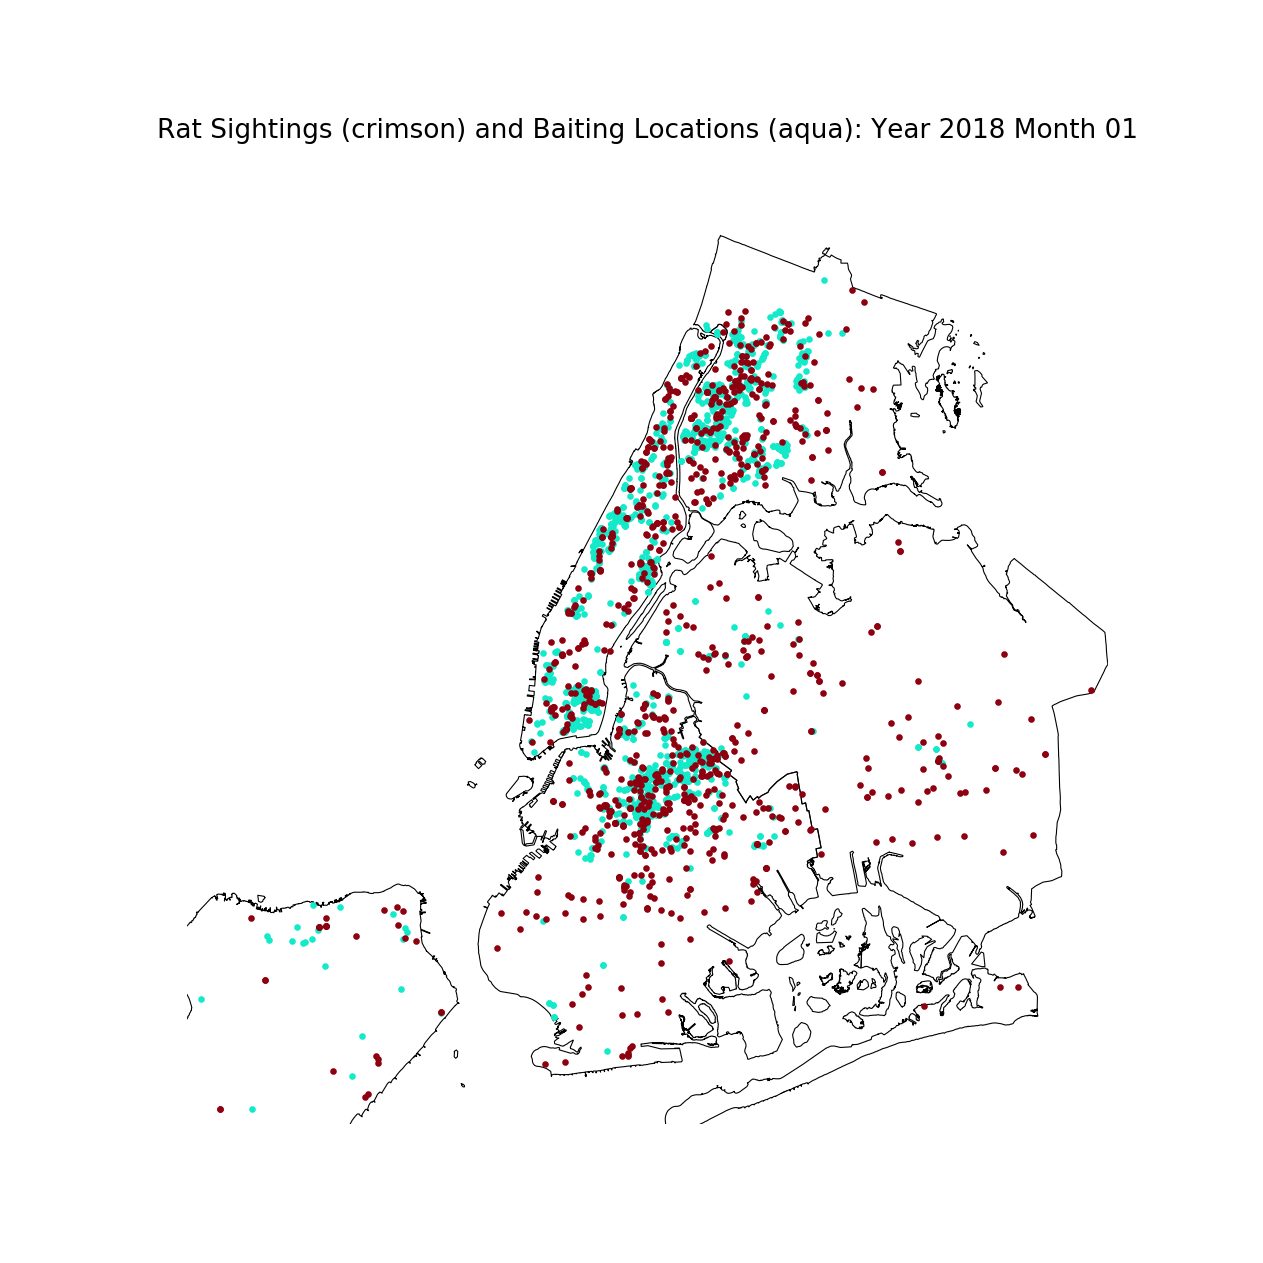

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


In [8]:
anim_data_sightings = dataset_sightings_locations.groupby('YearMonth') 
anim_data_bait = bait_interventions.groupby('YearMonth')

timepoints = dataset_sightings_locations['YearMonth'].unique()
timepoints.sort()
 
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

m = Basemap(llcrnrlat=40.55,urcrnrlat=40.95,llcrnrlon=-74.2, urcrnrlon=-73.7, lat_ts=40.5, resolution='c', projection='merc')
m.readshapefile('geo_export_466a4803-d862-4a61-914b-7783568f80f5', 'comarques')
m.drawmapboundary(fill_color='#ffffff', linewidth=.0)

xi,yi = m(0, 0)
pointi = m.plot(xi, yi, 'ro', markersize=2, color = 'xkcd:aqua')[0]

x,y = m(0, 0)
point = m.plot(x, y, 'ro', markersize=2, color = 'xkcd:crimson')[0]



def init():
    pointi.set_data([], [])
    return pointi, point,

def animate(i):
    xi, yi = m(anim_data_bait.get_group(timepoints[i]).LONGITUDE.tolist(), anim_data_bait.get_group(timepoints[i]).LATITUDE.tolist())
    pointi.set_data(xi, yi)
    x, y = m(anim_data_sightings.get_group(timepoints[i]).Longitude.tolist(), anim_data_sightings.get_group(timepoints[i]).Latitude.tolist())
    point.set_data(x, y)
    plt.title('Rat Sightings (crimson) and Baiting Locations (aqua): Year ' + str(anim_data_sightings.get_group(timepoints[i]).iloc[0,0].year) + ' Month '+ str(anim_data_sightings.get_group(timepoints[i]).iloc[0,0].month).zfill(2))
#     ###frames for makeing a gif:
#     plt.savefig('RatSightingsBaiting'+ str(i).zfill(2) +'.jpg', dpi=200)
    return pointi, point,

anim_bait = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(timepoints)-1, interval=100, blit=True,repeat = False, save_count=len(timepoints))

plt.show()



<IPython.core.display.Javascript object>


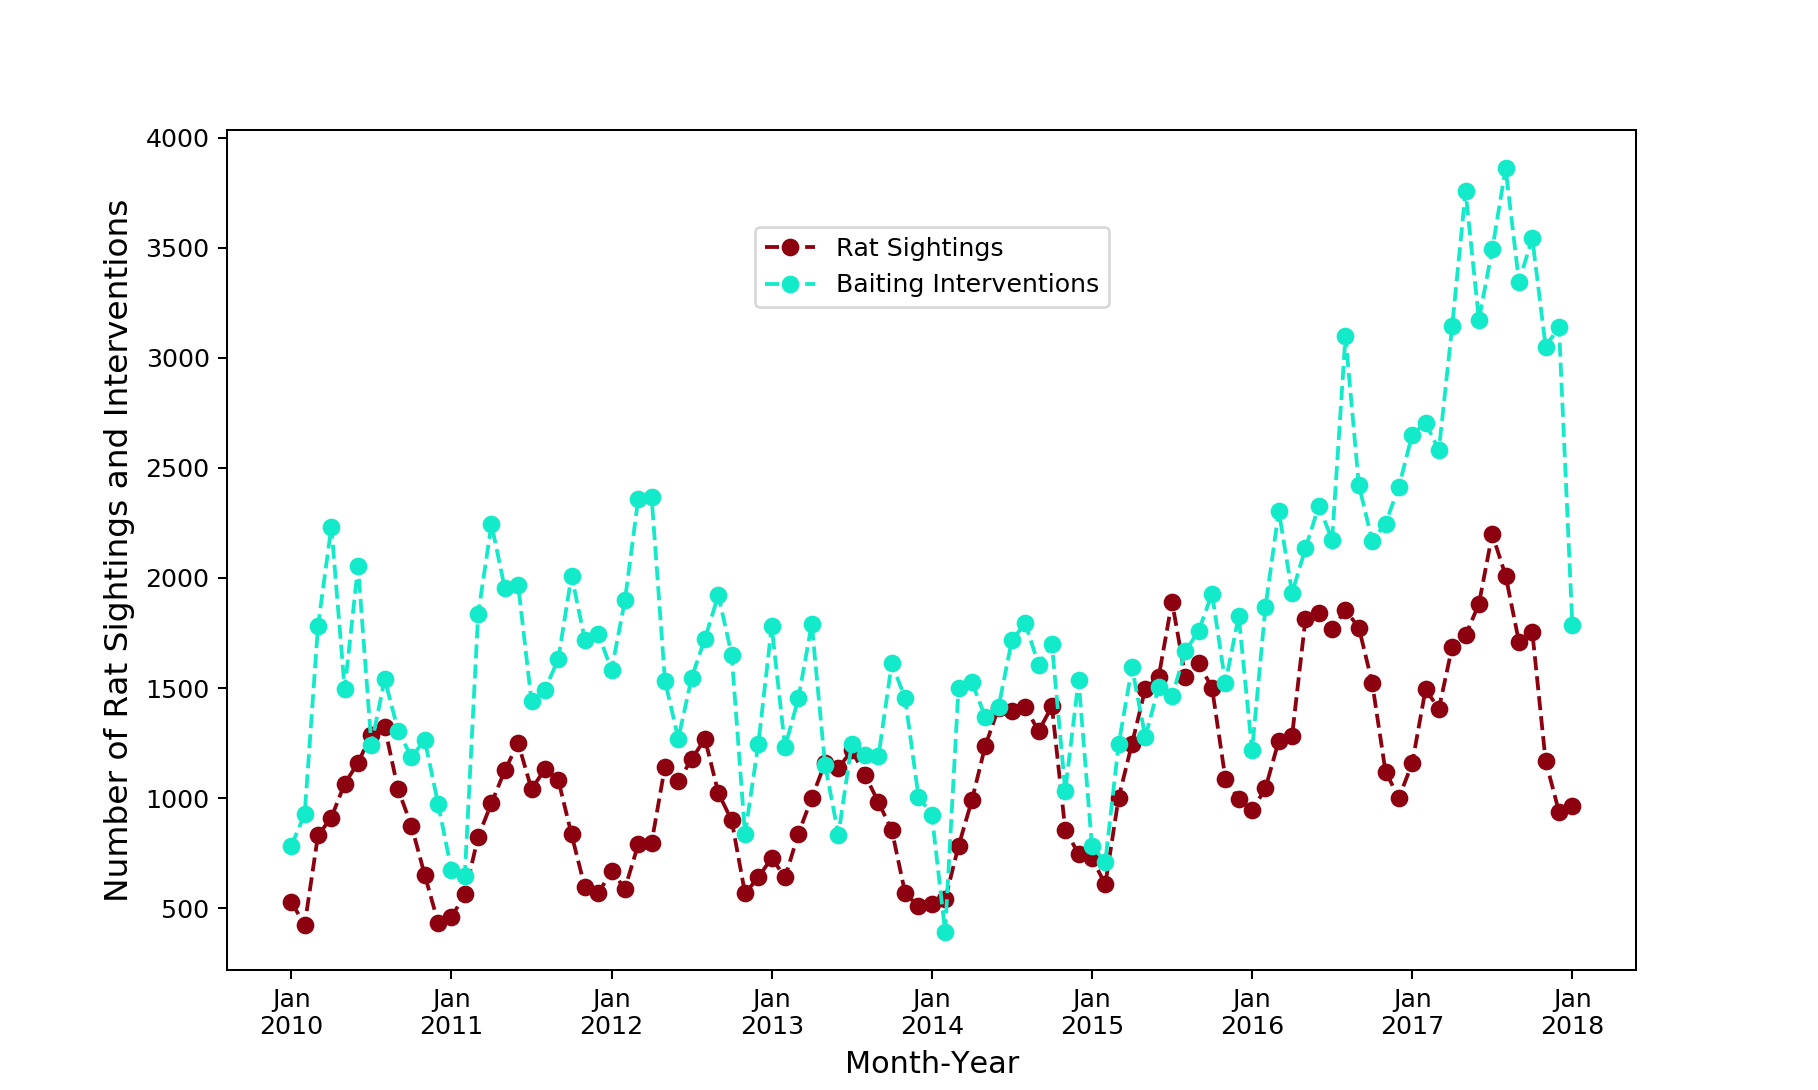

In [9]:
### a more elegant way of grouping by month and producing the plot number of sightings and baitings as function of time:
fig = plt.figure(figsize=(10, 6))

sightings_by_month = dataset_sightings.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='M')])['Descriptor'].size().reset_index().sort_values('Created Date')
baitings_by_month = bait_interventions.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='M')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')

plt.plot(timepoints[:-1],sightings_by_month['Descriptor'].values[:-1],linestyle='--', marker='o',color = 'xkcd:crimson',label="Rat Sightings")
plt.plot(timepoints[:-1],baitings_by_month['RESULT'].values,linestyle='--', marker='o',color = 'xkcd:aqua', label="Baiting Interventions")
plt.xticks(['2010-01','2011-01','2012-01','2013-01','2014-01','2015-01','2016-01','2017-01','2018-01'],
           ["Jan\n2010","Jan\n2011","Jan\n2012","Jan\n2013","Jan\n2014","Jan\n2015","Jan\n2016","Jan\n2017","Jan\n2018"])
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Rat Sightings and Interventions", fontsize=13)
plt.legend(loc=9, bbox_to_anchor=(0.5, 0.9))
plt.savefig('RatSightingsBaiting.jpg', dpi=200)
plt.show()

A little note on biological growth: Biological exponential growth is the exponential growth of biological organisms. When the resources availability is unlimited in the habitat, the population of an organism living in the habitat grows in an exponential fashion. The increase in numbers is proportional to the population size so the rate of change is not constant. But exponential growth has fixed PERCENT increase at regular time intervals.<br><br>

NOTE: I assume that the number of rat sightings is a measure of the number of rats, so my assumption is that it is sampling the rat population. The numbers in the dataset of interventions on the other hand are actual numbers of interventions, not a sample, I have the total 'population' data for interventions.<br><br>
I want to examine and quantify how the city has responded to the increasing number of rat sightings - first, from one year to the next, has there been a change in number of rat sightings? If so, has there been a change in number of interventions and if so, has that had any observable effect on the number of sightings? I will first check how the number of sightings has changed. First I will look at the total number of weekly sightings across the whole city and then total number of weekly baiting interventions across the whole city. I do this for every week, across years 2010-2017. <br>
Here I will plot the yearly average number of sightings per week vs. yearly average number of baitings per week. For every year.

In [9]:
### grouping by week
sightings_by_week = dataset_sightings.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='W-MON')])['Descriptor'].size().reset_index().sort_values('Created Date')
baitings_by_week = bait_interventions.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='W-MON')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')

### grouping by month
sightings_by_month = dataset_sightings.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='M')])['Descriptor'].size().reset_index().sort_values('Created Date')
baitings_by_month = bait_interventions.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='M')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')

### how has yearly Average number of sightings per week and Average number of baitings per week changed over the years?

# fig = plt.figure(figsize=(7, 5))

sightings_by_year = {}
baitings_by_year = {}

for i in range(2010,2018):
    sightings_by_week_this_year = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year==i].reset_index()
    baitings_by_this_year = baitings_by_week.loc[baitings_by_week['INSPECTION_DATE'].dt.year==i].reset_index()
    
    sightings_by_year[i] = sightings_by_week_this_year['Descriptor'].values
    baitings_by_year[i] = baitings_by_this_year['RESULT'].values

<IPython.core.display.Javascript object>


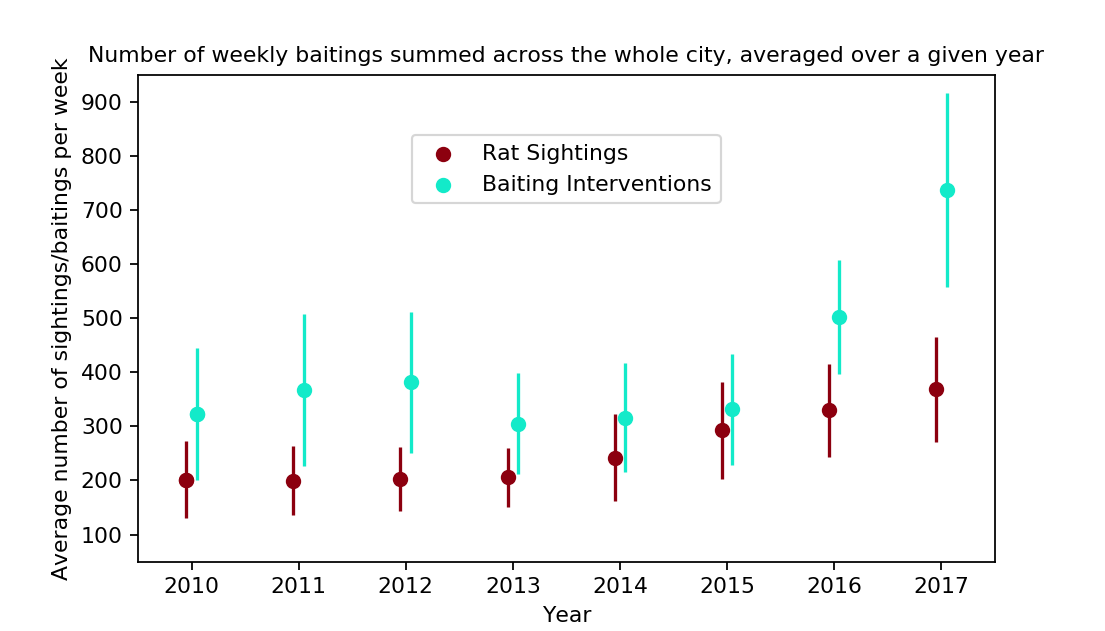

In [10]:
fig = plt.figure(figsize=(7, 4))

plt.scatter(2010-0.05,sightings_by_year[2010].mean(),color = 'xkcd:crimson',label = "Rat Sightings")
plt.scatter(2010+0.05,baitings_by_year[2010].mean(),color = 'xkcd:aqua',label = "Baiting Interventions")
    
for i in range(2010,2018):
    plt.scatter(i-0.05,sightings_by_year[i].mean(),color = 'xkcd:crimson')
    plt.errorbar(i-0.05,sightings_by_year[i].mean(), yerr = sightings_by_year[i].std(),color = 'xkcd:crimson')
    plt.scatter(i+0.05,baitings_by_year[i].mean(),color = 'xkcd:aqua')
    plt.errorbar(i+0.05,baitings_by_year[i].mean(), yerr = baitings_by_year[i].std(),color = 'xkcd:aqua')
plt.xlabel("Year", fontsize=10)
plt.ylabel("Average number of sightings/baitings per week", fontsize=10)   
plt.title("Number of weekly baitings summed across the whole city, averaged over a given year", fontsize=10)   
plt.legend(loc=9, bbox_to_anchor=(0.5, 0.9))
plt.axis([2009.5,2017.5, 50,950])
plt.show()
plt.savefig('SightingsBaitingsByYear.jpg', dpi=200)


In [11]:
### some statistical significance testing showing that number of rat sightings has increased 
sightings_2010 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year ==2010].reset_index()
sightings_2011 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year ==2011].reset_index()
sightings_2012 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year ==2012].reset_index()
sightings_2013 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year ==2013].reset_index()
### do an ANOVA on these
f, p = stats.f_oneway(sightings_2010['Descriptor'],sightings_2011['Descriptor'],sightings_2012['Descriptor'],sightings_2013['Descriptor'])

###alternative way of doing anova:
# sightings_2010_11_12_13 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year<=2013].reset_index()
# df_sightings_2010_11_12_13 = pd.DataFrame({'sightings' : sightings_2010_11_12_13['Descriptor'], 'year' : sightings_2010_11_12_13['Created Date'].dt.year})
# mod = smf.ols('sightings ~ C(year)', df_sightings_2010_11_12_13).fit() ### linear regression
# aov_table = sm.stats.anova_lm(mod, typ=2) ### get an anova summary and the p value is aov_table.prod()[3]

print ('I look at the number of rat sightings per week, I group this into separate years 2010, 2011, 2012, 2013 \n'
       +'and the p-value of a one-way ANOVA is {0:.4f}. So on average the number of rat sightings from 2010-2013 didnt change.'.format(p))

sightings_2013 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year==2013].reset_index()
sightings_2014 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year==2014].reset_index()
sightings_2015 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year==2015].reset_index()
sightings_2016 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year==2016].reset_index()
sightings_2017 = sightings_by_week.loc[sightings_by_week['Created Date'].dt.year==2017].reset_index()

t13_14, p13_14 = stats.ttest_ind(sightings_2013['Descriptor'],sightings_2014['Descriptor'])
t14_15, p14_15 = stats.ttest_ind(sightings_2014['Descriptor'],sightings_2015['Descriptor'])
t15_16, p15_16 = stats.ttest_ind(sightings_2015['Descriptor'],sightings_2016['Descriptor'])
t16_17, p16_17 = stats.ttest_ind(sightings_2016['Descriptor'],sightings_2017['Descriptor'])

print ('I do the same for separate years 2013, 2014, 2015, 2016, 2017 and I compare consecutive years with two-sample\n'
      +'t-tests (I could also do ANOVAs). For 2013 compared to 2014, the p-value is {0:.6f}, \n'.format(p13_14)
       +'for 2014 compared to 2015, the p-value is {0:.6f}, '.format(p14_15)
      +'for 2015 compared to 2016, the p-value is {0:.6f}, '.format(p15_16)
      +'and for 2016 compared to 2017, the p-value is {0:.6f}.'.format(p16_17))

I look at the number of rat sightings per week, I group this into separate years 2010, 2011, 2012, 2013 
and the p-value of a one-way ANOVA is 0.9642. So on average the number of rat sightings from 2010-2013 didnt change.
I do the same for separate years 2013, 2014, 2015, 2016, 2017 and I compare consecutive years with two-sample
t-tests (I could also do ANOVAs). For 2013 compared to 2014, the p-value is 0.010063, 
for 2014 compared to 2015, the p-value is 0.003121, for 2015 compared to 2016, the p-value is 0.036721, and for 2016 compared to 2017, the p-value is 0.032659.


In [12]:
# mc = MultiComparison(df_sightings_2014_15_16_17['sightings'],df_sightings_2014_15_16_17['year'])
# result = mc.tukeyhsd()
# print(result)

So this means that the increase of average rat sightings per week in 2014 compared to 2013 is statistically significant, and from then on the increase in rat sightings every consecutive is statistically significant. This analysis could maybe be improved if I instead used a trend test not just pair-wise comparisons of consecutive years.  

In [13]:
mean_weekly_sightings = [sightings_by_year[2010].mean(), sightings_by_year[2011].mean(),sightings_by_year[2012].mean(),sightings_by_year[2013].mean(),sightings_by_year[2014].mean(), sightings_by_year[2015].mean(), sightings_by_year[2016].mean(), sightings_by_year[2017].mean()]
delta_sightings_one_year_apart = [x - mean_weekly_sightings[i - 1] for i, x in enumerate(mean_weekly_sightings)][1:]
percent_more_sightings_one_year_apart = [(x - mean_weekly_sightings[i - 1])/mean_weekly_sightings[i - 1] for i, x in enumerate(mean_weekly_sightings)][1:]
print ('So the yearly average number of rat sightings per week has increased steadily starting in 2014, the increase was\n'
       +'statistically sigificant starting in 2014, since then the number of sightings per week on average increases by \n'
       +'approximately {:.1f} weekly sightings every year.'.format(np.mean(delta_sightings_one_year_apart[3:])))
print ('So in %, in 2014 there were on average {:.2f}% more weekly sightings than in 2013.'.format(percent_more_sightings_one_year_apart[3]*100))
print ('In 2015 there were on average {:.2f}% more weekly sightings than in 2014.'.format(percent_more_sightings_one_year_apart[4]*100))
print ('In 2016 there were on average {:.2f}% more weekly sightings than in 2015.'.format(percent_more_sightings_one_year_apart[5]*100))
print ('In 2017 there were on average {:.2f}% more weekly sightings than in 2016.'.format(percent_more_sightings_one_year_apart[6]*100))

So the yearly average number of rat sightings per week has increased steadily starting in 2014, the increase was
statistically sigificant starting in 2014, since then the number of sightings per week on average increases by 
approximately 40.6 weekly sightings every year.
So in %, in 2014 there were on average 17.31% more weekly sightings than in 2013.
In 2015 there were on average 21.09% more weekly sightings than in 2014.
In 2016 there were on average 12.52% more weekly sightings than in 2015.
In 2017 there were on average 11.90% more weekly sightings than in 2016.


As the average number of rat sightings per week has increased, the average number of rat baitings has increased as well.

In [14]:
### no need to do this:
# df_baitings = pd.DataFrame({'baitings' : baitings_by_week['RESULT'], 'year' : baitings_by_week['INSPECTION_DATE'].dt.year})
# mc = MultiComparison(df_baitings['baitings'],df_baitings['year'])
# result = mc.tukeyhsd()
# print(result)

In [16]:
mean_weekly_baiting = [baitings_by_year[2010].mean(), baitings_by_year[2011].mean(),baitings_by_year[2012].mean(),baitings_by_year[2013].mean(),baitings_by_year[2014].mean(), baitings_by_year[2015].mean(), baitings_by_year[2016].mean(), baitings_by_year[2017].mean()]
delta_baitings_from_one_year_to_next = [x - mean_weekly_baiting[i - 1] for i, x in enumerate(mean_weekly_baiting)][1:]
percent_more_baitings_from_one_year_to_next = [(x - mean_weekly_baiting[i - 1])/mean_weekly_baiting[i - 1] for i, x in enumerate(mean_weekly_baiting)][1:]
print ('In 2011 there were on average {:.2f}% more weekly baitings than the year before.'.format(percent_more_baitings_from_one_year_to_next[0]*100))
print ('that is on average {:.1f} more baiting interventions per week than the year before.'.format(delta_baitings_from_one_year_to_next[0]))
print ('In 2012 there were on average {:.2f}% more weekly baitings than the year before.'.format(percent_more_baitings_from_one_year_to_next[1]*100))
print ('that is on average {:.1f} more baiting interventions per week than the year before.'.format(delta_baitings_from_one_year_to_next[1]))
print ('In 2013 there were on average {:.2f}% more weekly baitings than the year before.'.format(percent_more_baitings_from_one_year_to_next[2]*100))
print ('that is on average {:.1f} more baiting interventions per week than the year before.'.format(delta_baitings_from_one_year_to_next[2]))
print ('In 2014 there were on average {:.2f}% more weekly baitings than the year before.'.format(percent_more_baitings_from_one_year_to_next[3]*100))
print ('that is on average {:.1f} more baiting interventions per week than the year before.'.format(delta_baitings_from_one_year_to_next[3]))
print ('In 2015 there were on average {:.2f}% more weekly baitings than the year before.'.format(percent_more_baitings_from_one_year_to_next[4]*100))
print ('that is on average {:.1f} more baiting interventions per week than the year before.'.format(delta_baitings_from_one_year_to_next[4]))
print ('In 2016 there were on average {:.2f}% more weekly baitings than the year before.'.format(percent_more_baitings_from_one_year_to_next[5]*100))
print ('that is on average {:.1f} more baiting interventions per week than the year before.'.format(delta_baitings_from_one_year_to_next[5]))
print ('In 2017 there were on average {:.2f}% more weekly baitings than the year before.'.format(percent_more_baitings_from_one_year_to_next[6]*100))
print ('that is on average {:.1f} more baiting interventions per week than the year before.'.format(delta_baitings_from_one_year_to_next[6]))

In 2011 there were on average 13.71% more weekly baitings than the year before.
that is on average 44.2 more baiting interventions per week than the year before.
In 2012 there were on average 3.91% more weekly baitings than the year before.
that is on average 14.3 more baiting interventions per week than the year before.
In 2013 there were on average -19.93% more weekly baitings than the year before.
that is on average -76.0 more baiting interventions per week than the year before.
In 2014 there were on average 3.63% more weekly baitings than the year before.
that is on average 11.1 more baiting interventions per week than the year before.
In 2015 there were on average 4.75% more weekly baitings than the year before.
that is on average 15.0 more baiting interventions per week than the year before.
In 2016 there were on average 51.51% more weekly baitings than the year before.
that is on average 170.8 more baiting interventions per week than the year before.
In 2017 there were on averag

<IPython.core.display.Javascript object>


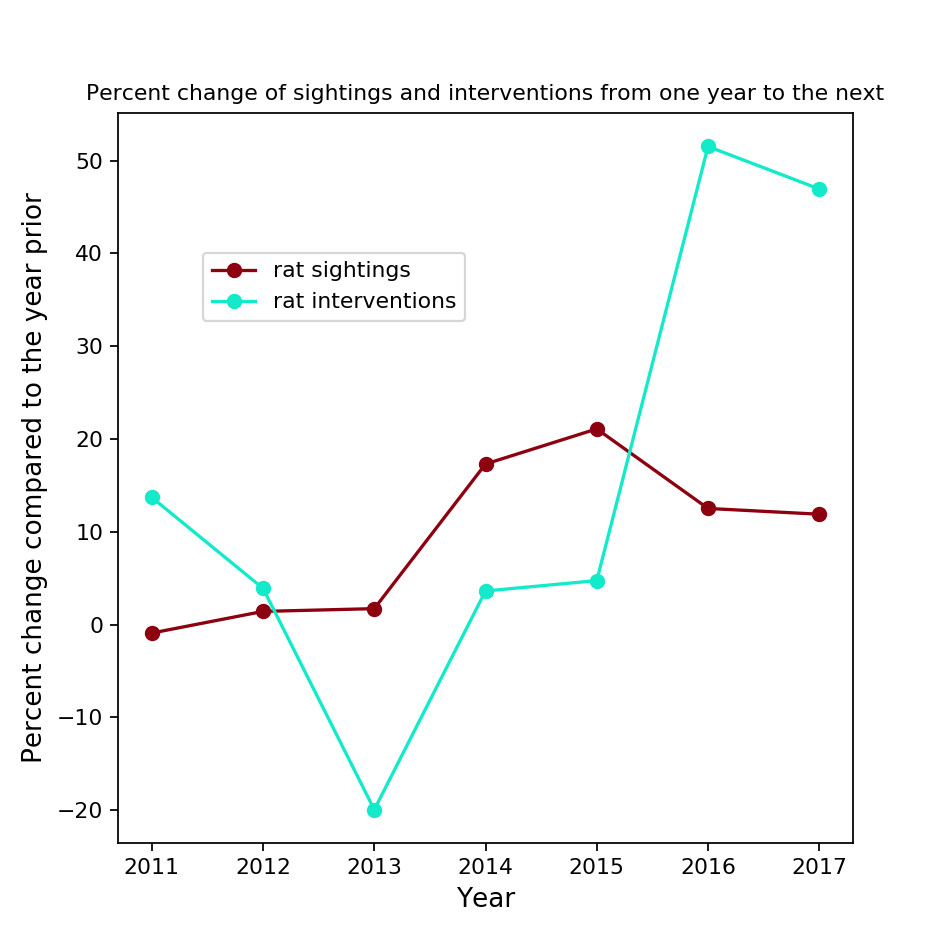

In [17]:
fig = plt.figure(figsize=(6, 6))

years = ['2011','2012','2013','2014', '2015', '2016', '2017']
percent_sightings_increase = {}
percent_baitings_increase = {}

for i in range(2011,2018):
    percent_sightings_increase[i] = 100*(sightings_by_year[i].mean()-sightings_by_year[i-1].mean())/sightings_by_year[i-1].mean()
    percent_baitings_increase[i] = 100*(baitings_by_year[i].mean()-baitings_by_year[i-1].mean())/baitings_by_year[i-1].mean()
    
#     plt.errorbar(sightings_by_year[i].mean(),baitings_by_year[i].mean(), xerr = sightings_by_year[i].std(), yerr = baitings_by_year[i].std(),color = my_colors[i-2010])
#     plt.scatter(sightings_by_year[i].mean(),baitings_by_year[i].mean(),color = my_colors[i-2010], label=str(i))
    
plt.plot(years,percent_sightings_increase.values(),'-o' ,color = 'xkcd:crimson',label='rat sightings')   
plt.plot(years,percent_baitings_increase.values(),'-o', color = 'xkcd:aqua',label='rat interventions')    
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percent change compared to the year prior", fontsize=12)   
plt.title("Percent change of sightings and interventions from one year to the next", fontsize=10)   

plt.legend(loc=3, bbox_to_anchor=(0.1, 0.7))
plt.show()

So the number of weekly rat sightings has increased starting in 2014, on average by approximately the same amount every year (every year on average about 40 more rat sightings per week). This meant 17% more in 2014 than the year before, 21% more in 2015 than the year before and then 'just' 13% in 2016 and 12% in 2017 compared to the year before. So the City's response has strengthened only starting in 2016, since then there has been around 51% more weekly interventions in 2016 compared to the year before and additional increase of about 46% more weekly interventions in 2017 compared to the year before. And I can observe that with this increase of interventions in 2016 and 2017, the percent increase in number of sightings went from 17% and 21% in 2014 and 2015, down to an increase in sightings of 'just' 13% in 2016 and 12% in 2017. IS THIS A SIGNIFICANT CHANGE in percent increase? Let me check this. I will compare the rate of change from one year to the next:

<IPython.core.display.Javascript object>


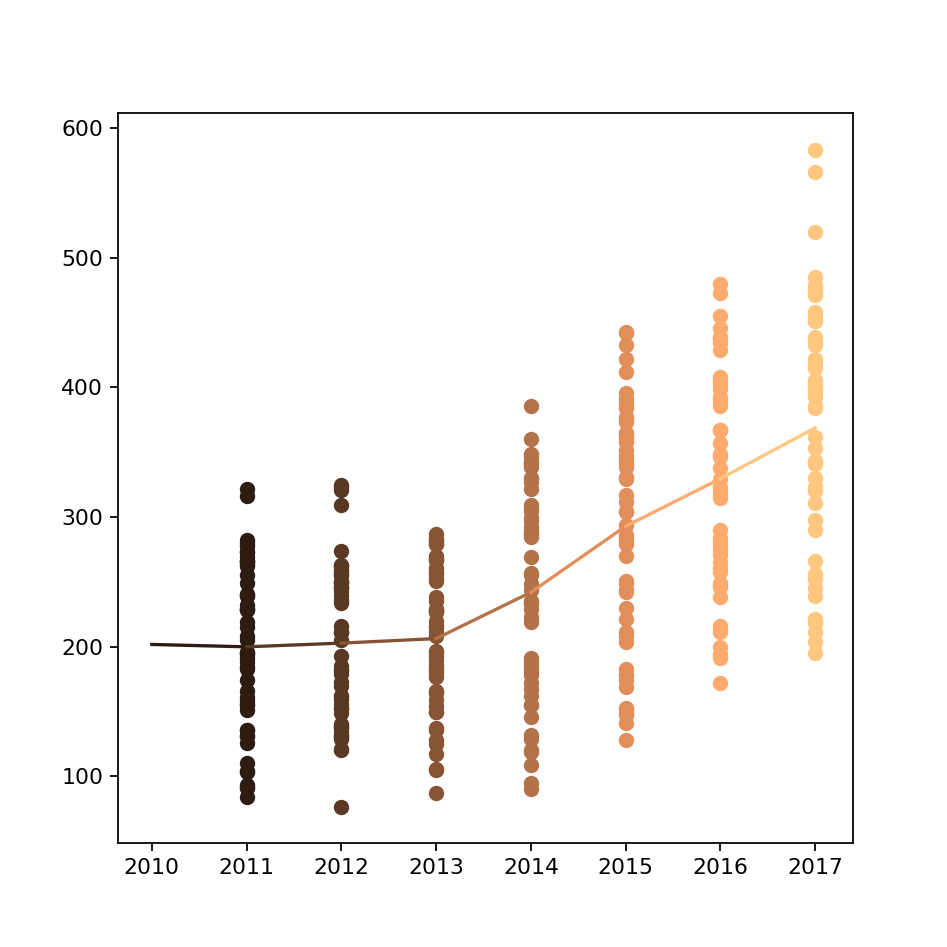

p-value of comparing slope 2010-2011 to slope 2011-2012 is 0.3981.
p-value of comparing slope 2011-2012 to slope 2012-2013 is 0.4845.
p-value of comparing slope 2012-2013 to slope 2013-2014 is 0.0352.
p-value of comparing slope 2013-2014 to slope 2014-2015 is 0.2400.
p-value of comparing slope 2014-2015 to slope 2015-2016 is 0.7233.
p-value of comparing slope 2015-2016 to slope 2016-2017 is 0.4597.


In [18]:
### preparing data for linear regressions and then do t-test on summary data which is slopes and their std errors
fig = plt.figure(figsize=(6, 6))

cmap = plt.get_cmap('copper')
my_colors = [cmap(i) for i in np.linspace(0, 1, 8)]

slopes = {} ### will contain the slope of linear regression between consecutive years
errors = {} ### will contain std errors of slopes between consecutive years
numberobs = {} ### will containg the number of points on which the regression is done

for i in range(2011,2018):
    plt.scatter([i]*len(sightings_by_year[i]),sightings_by_year[i], color = my_colors[i-2010])
    X = np.concatenate(([i]*len(sightings_by_year[i]),[i-1]*len(sightings_by_year[i-1])),axis=0)
    X = sm.add_constant(X)
    Y = np.concatenate((sightings_by_year[i],sightings_by_year[i-1]),axis=0)
    lg = sm.OLS(Y,X).fit()
    plt.plot(X[:,1], lg.fittedvalues,color = my_colors[i-2010])
    slopes[i] = lg.params[1]
    errors[i] = lg.bse[1]
    numberobs[i] = Y.size
    
plt.show()        

### now a t-test comparing consecutive slopes based on mean and std err for each slope
for i in range(2012,2018):
    t_value = ((slopes[i] - slopes[i-1])/np.sqrt(errors[i]**2 + errors[i-1]**2)) #bse = standard error
    p_value = stats.t.sf(t_value,numberobs[i] + numberobs[i-1] -4) #calculate p-value from t-statistic lookup tables
    print ('p-value of comparing slope '+ str(i-2)+'-'+str(i-1)+' to slope '+ str(i-1)+'-'+str(i)+' is {:.4f}.'.format(p_value))


So the only difference between consecutive years is between 2012-2013 and 2013-2014. Therefore if the slope from 2013 on is constant, it is this:

In [19]:
### linear regression through all 2013, 2014, 2015, 2016, 2017 points
X = np.concatenate(([2013]*len(sightings_by_year[2013]),[2014]*len(sightings_by_year[2014]),[2015]*len(sightings_by_year[2015]),[2016]*len(sightings_by_year[2016]),[2017]*len(sightings_by_year[2017])),axis=0)
X = sm.add_constant(X)
Y = np.concatenate((sightings_by_year[2013],sightings_by_year[2014],sightings_by_year[2015],sightings_by_year[2016],sightings_by_year[2017]),axis=0)
lg_all = sm.OLS(Y,X).fit()
# plt.plot(X[:,1], lg_all.fittedvalues,color = 'k')
print ('The slope is {:.4f}.'.format(lg_all.params[1]))
print ('The std error of the slope is {:.4f}.'.format(lg_all.bse[1]))


The slope is 41.2885.
The std error of the slope is 3.6430.


So I think all I can conclude from this is that from 2013 on the rate of growth has been constant. Which is not exponential growth. The numbers started increasing in 2014 without more interventiosn from the City, then continued to grow for another year in 2015 without increased interventiosn from the City. The rate of growth from 2013-2014 and then 2014-2015 are not siginificantly different based on the data I have. But with exponential growth it could be that only the thir year and the fourth we could start to see that the rate of growth curves up and doesn;t remain constat. However in 2016 the City did ramp up the number of observations and the rate of growth of observations is kept the same in 2016 and in 2017. So the fact that it is not an exponential growth as the City comes up with more interventions could likely be due to ramed up interventions, but it could also have to do with other factors of course, like saturation of natural habitat, etc.

Now I want to explore the City's strategy a bit, how they distribute interventions in time and space. I will first check how the number of weekly baiting interventions is related to the number of weekly rat sightings when summed across the whole city. Does the City respond to a week with more rat sightings with more baiting interventions that week?

<IPython.core.display.Javascript object>


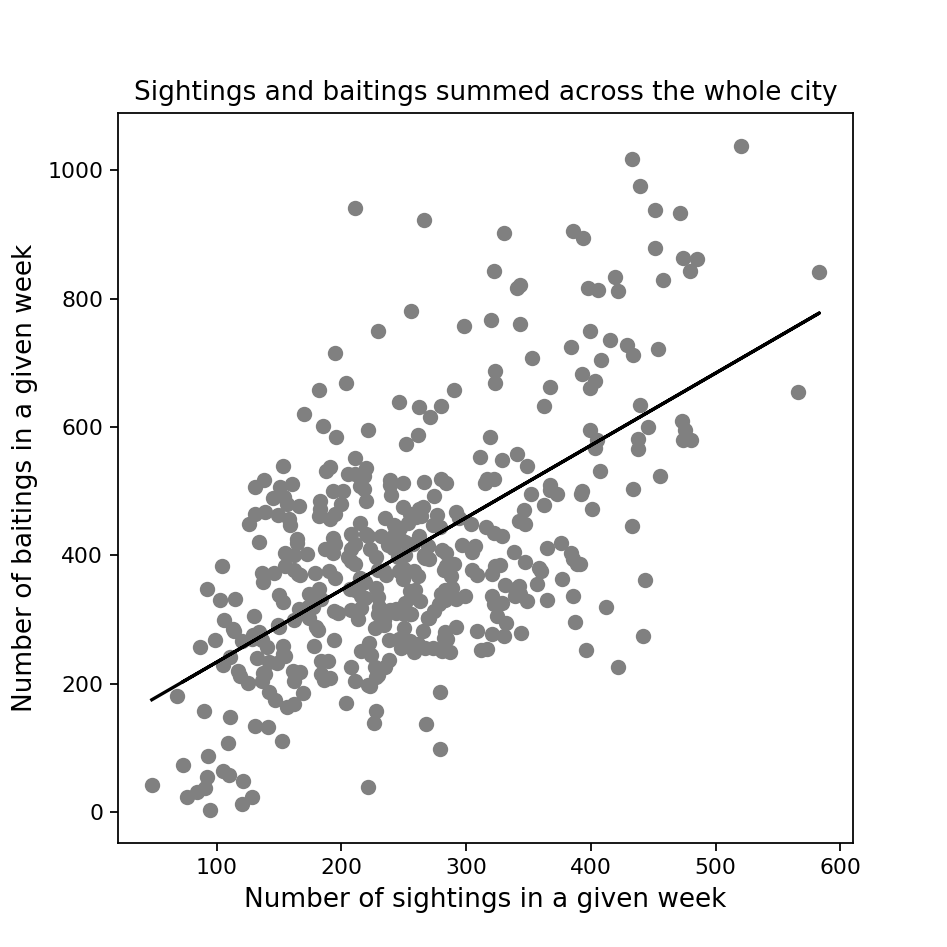

p-values of intersection and slope, respectively, are [  4.07535439e-09   4.60732152e-42]
Intersection estimate and slope estimate, respectively, are [ 121.11686288    1.12584281]
Standard error of intersection estimate and Standard error of slope estimate, are [ 20.16034145   0.07389128]
R^2 of the fit is 0.35543159160759774
95% confidence interval for intersection is [  81.48939751  160.74432824]
95% confidence interval for slope is [ 0.98060101  1.27108461]


In [20]:
###linear regression on the whole dataset when grouped by week:
baitings_by_week.columns = ['type', 'Created Date','Inspections']
sightings_and_baitings_by_week = pd.merge(baitings_by_week.iloc[:,1:3],sightings_by_week, how='right', on=['Created Date']).fillna(0).sort_values('Created Date')
sightings_and_baitings_by_week.columns = ['Created Date','baitings','agency','sightings']

X = sightings_and_baitings_by_week['sightings'].values
X = sm.add_constant(X)
Y = sightings_and_baitings_by_week['baitings'].values
lg = sm.OLS(Y,X).fit()

fig = plt.figure(figsize=(6, 6))
plt.scatter(sightings_and_baitings_by_week['sightings'].values,sightings_and_baitings_by_week['baitings'].values, marker='o',color = 'gray')
plt.plot(X[:,1], lg.fittedvalues,'k')
plt.title("Sightings and baitings summed across the whole city", fontsize=12)
plt.xlabel("Number of sightings in a given week", fontsize=12)
plt.ylabel("Number of baitings in a given week", fontsize=12) 
plt.savefig('SightVsBaitWholeCity.jpg', dpi=200)
plt.show()
print ('p-values of intersection and slope, respectively, are {}'.format(lg.pvalues))
print ('Intersection estimate and slope estimate, respectively, are {}'.format(lg.params))
print ('Standard error of intersection estimate and Standard error of slope estimate, are {}'.format(lg.bse))
print ('R^2 of the fit is {}'.format(lg.rsquared))
print ('95% confidence interval for intersection is {}'.format(lg.conf_int(alpha=0.05, cols=None)[0]))
print ('95% confidence interval for slope is {}'.format(lg.conf_int(alpha=0.05, cols=None)[1]))

Therefore the City does respond to more weekly rat sightings in a week with more baiting interventions in that week. Linear regression results suggest that when looking over the whole time span 2010-2018, the City's strategy has been that for every 100 additional rat sightings in a week, there are on average between 98 and 127 additional rat baiting interventions that week. And from the intercept estimate we can conclude that in absence of any rat sightings, the number of weekly baiting interventions would be on average somewhere between 81 and 161. <br>


Now I am interested how (or if) this strategy has changed over the years, in particular since 2016 when there has been a noticable increase in rat bating interventions.

<IPython.core.display.Javascript object>


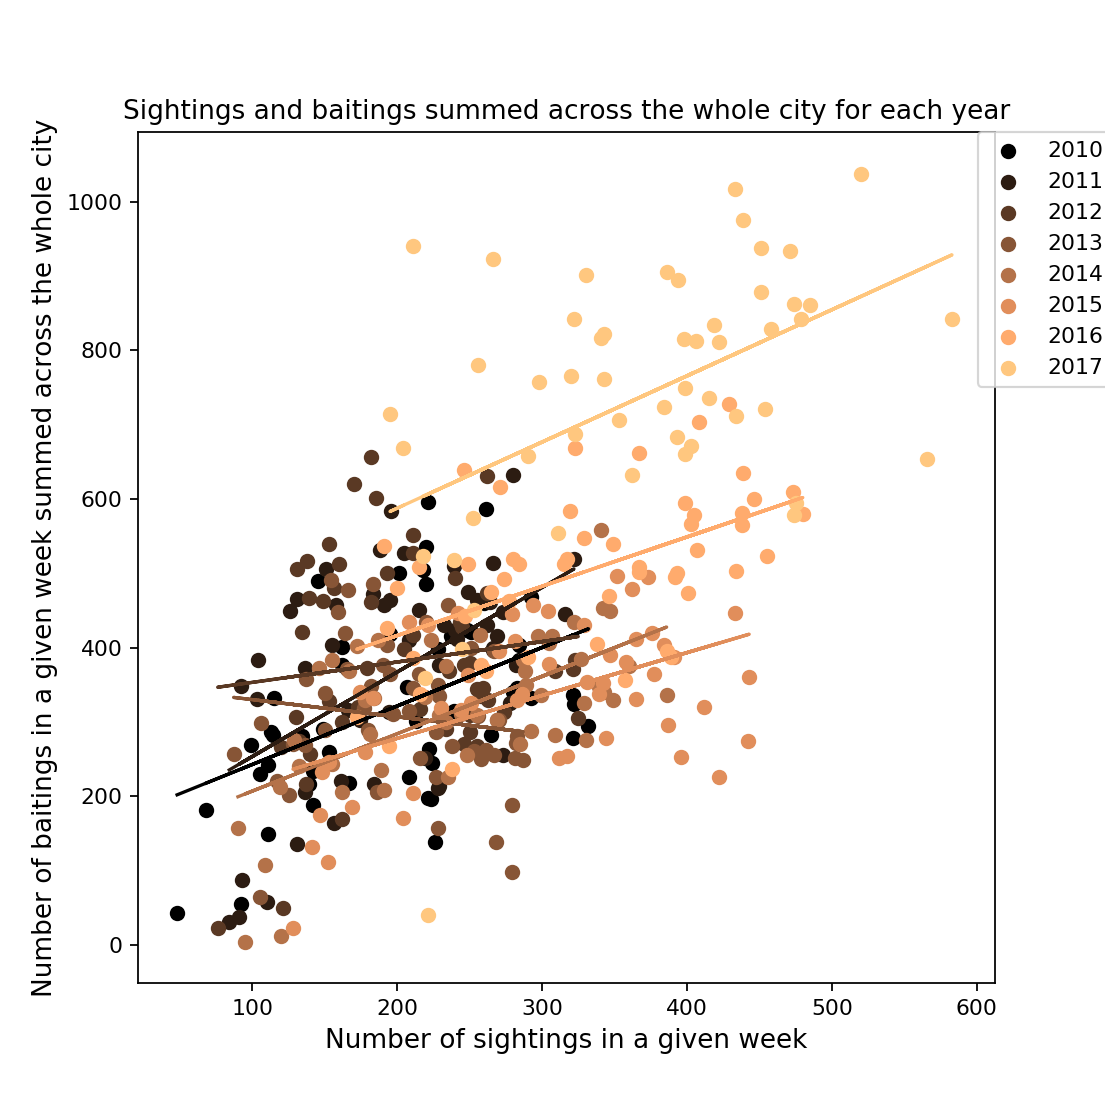

In [21]:
### linear regression for each year separately
fittedvalues_by_year = {}
pvalues_by_year = {}
sightings_by_year = {}
baitings_by_year = {}
params_by_year = {}
se_by_year = {}  ###standard errors for each parameter estimate
rsq_by_year = {}
conf_int_by_year = {} 

fig = plt.figure(figsize=(7, 7))

for i in range(2010,2018):
    sightings_and_baits_by_week_this_year = sightings_and_baitings_by_week.loc[sightings_by_week['Created Date'].dt.year==i].reset_index()

    X = sightings_and_baits_by_week_this_year['sightings'].values
    X = sm.add_constant(X)
    Y = sightings_and_baits_by_week_this_year['baitings'].values
    lg_this_year = sm.OLS(Y,X).fit()
    
    fittedvalues_by_year[str(i)+'X'] = X[:,1]
    fittedvalues_by_year[str(i)+'Y'] = lg_this_year.fittedvalues
    pvalues_by_year[i] = lg_this_year.pvalues
    sightings_by_year[i] = sightings_and_baits_by_week_this_year['sightings'].values
    baitings_by_year[i] = sightings_and_baits_by_week_this_year['baitings'].values
    params_by_year[i] = lg_this_year.params
    se_by_year[i] = lg_this_year.bse
    rsq_by_year[i] = lg_this_year.rsquared
    conf_int_by_year[i] = lg_this_year.conf_int(alpha=0.05, cols=None)
    
    plt.scatter(sightings_and_baits_by_week_this_year['sightings'].values,sightings_and_baits_by_week_this_year['baitings'].values, marker='o',color = my_colors[i-2010],label = str(i))
    plt.plot(X[:,1], lg_this_year.fittedvalues,color = my_colors[i-2010])

plt.legend(bbox_to_anchor=(0.98, 1), loc=2, borderaxespad=0.)
plt.title("Sightings and baitings summed across the whole city for each year", fontsize=12)
plt.xlabel("Number of sightings in a given week", fontsize=12)
plt.ylabel("Number of baitings in a given week summed across the whole city", fontsize=12) 
plt.show()
plt.savefig('SightVsBaitWholeCity_byYear.jpg', dpi=200)


<IPython.core.display.Javascript object>


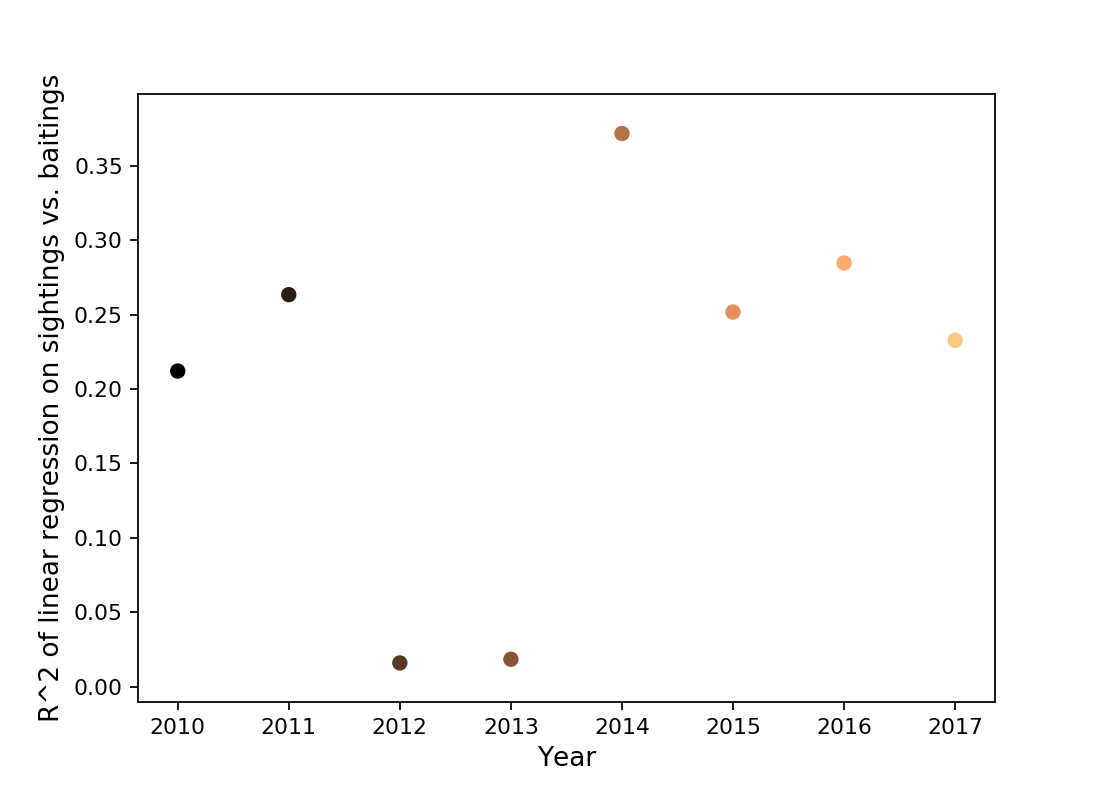

In [22]:
###plot R**2 values for the fit of each year
fig = plt.figure(figsize=(7, 5))
plt.scatter(list(rsq_by_year.keys()),list(rsq_by_year.values()),color = my_colors)
plt.xlabel("Year", fontsize=12)
plt.ylabel("R^2 of linear regression on sightings vs. baitings", fontsize=12)
plt.show()

The results of linear regression for each year suggest that the linear model is ok for most years except for years 2012 and 2013 (there R^2 is 0.016 and 0.018, respectively) so I will not include those two years when I look at how estimated parameter values (intercept and slope) have changed over the years.

<IPython.core.display.Javascript object>


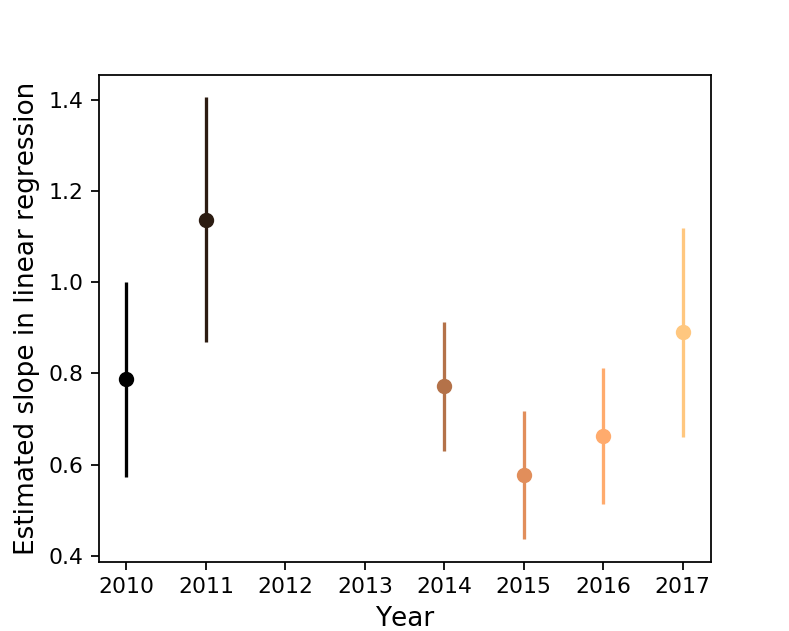

In [23]:
### How the estimate of the slope changes over years:
years = []
slopes = []
slopes_ses = []

fig = plt.figure(figsize=(5, 4))

for key, value in params_by_year.items():
    if key != 2012 and key != 2013:
        years = np.append(years,key)
        slopes = np.append(slopes,value[1])
        slopes_ses = np.append(slopes_ses,se_by_year[key][1])
        plt.errorbar(key,value[1],yerr = se_by_year[key][1], fmt='o',color = my_colors[key-2010])

plt.xlabel("Year", fontsize=12)
plt.ylabel("Estimated slope in linear regression", fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


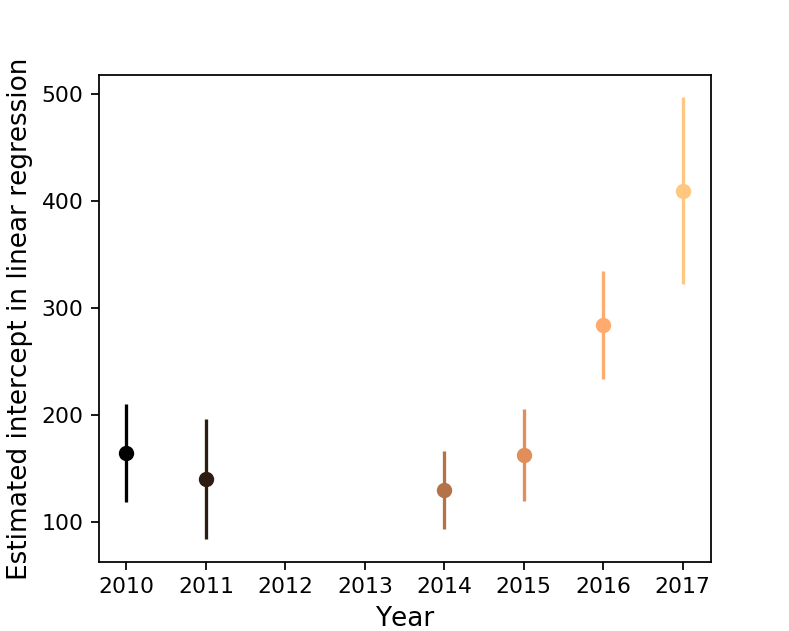

In [24]:
### How the estimate of the intercept changes over years:
years = []
intercepts = []
intercepts_ses = []

fig = plt.figure(figsize=(5, 4))

for key, value in params_by_year.items():
    if key != 2012 and key != 2013:
        years = np.append(years,key)
        intercepts = np.append(intercepts,value[0])
        intercepts_ses = np.append(intercepts_ses,se_by_year[key][0])
        plt.errorbar(key,value[0],yerr = se_by_year[key][0], fmt='o',color = my_colors[key-2010])

plt.xlabel("Year", fontsize=12)
plt.ylabel("Estimated intercept in linear regression", fontsize=12)
plt.show()


I will use ANCOVA (analysis of covariance), it is basically a statistical comparison of regression lines, to test if the strategy by the City has changed in the last two years - are the slopes equal if I compare 2014, 2015, 2016, 2017?

In [25]:
### preparing data for ANCOVA
sightings_and_baitings_by_week['Year'] = sightings_and_baitings_by_week['Created Date'].map(lambda x: x.strftime('%Y'))
new_df = sightings_and_baitings_by_week[sightings_and_baitings_by_week['Year'] != '2018']
new_df = new_df[new_df['Year'] != '2012']
new_df = new_df[new_df['Year'] != '2013']

### I'll just look at 2014, 2015, 2016, 2017
# new_df = new_df[new_df['Year'] != '2010']
# new_df = new_df[new_df['Year'] != '2011']

formula = 'baitings ~  sightings*C(Year)'  # ANCOVA formula
lm = smf.ols(formula, new_df)
slopes_test = lm.fit()
# aov_table = sm.stats.anova_lm(this_fit, typ=2) ### get an anova summary
# aov_table
slopes_test.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               baitings   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     60.78
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           1.10e-69
Time:                        17:45:52   Log-Likelihood:                -1911.1
No. Observations:                 312   AIC:                             3846.
Df Residuals:                     300   BIC:                             3891.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   164.0784     46.783      3.507      0.001      72.013     256.144
C(Year)[T.2011]             -24.2461     69.765     -0.348      0.728    -161.536     113.044
C(Year)[T.2014]             -34.3068     68.216     -0.503      0.615    -168.549      99.935
C(Year)[T.2015]              -1.5113     71.075     -0.021      0.983    -141.381     138.358
C(Year)[T.2016]             119.6204     78.013      1.533      0.126     -33.902     273.143
C(Year)[T.2017]             245.6003     77.228      3.180      0.002      93.623     397.578
sightings                     0.7870      0.219      3.601      0.000       0.357       1.217
sightings:C(Year)[T.2011]     0.3498      0.330      1.061      0.289      -0.299       0.999
sightings:C(Year)[T.2014]    -0.0152      0.293     -0.052      0.959      -0.591       0.561
sightings:C(Year)[T.2015]    -0.2103      0.280     -0.752      0.453      -0.761       0.340
sightings:C(Year)[T.2016]    -0.1239      0.285     -0.434      0.664      -0.685       0.437
sightings:C(Year)[T.2017]     0.1032      0.272      0.380      0.704      -0.431       0.637
==============================================================================
Omnibus:                       20.958   Durbin-Watson:                   1.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.614
Skew:                          -0.369   Prob(JB):                     1.52e-09
Kurtosis:                       4.606   Cond. No.                     6.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I need to look at the p-values in lines that correspond to the differences in slope: 'sightings:C(Year)[T.2011]','sightings:C(Year)[T.2014]','sightings:C(Year)[T.2015]',  'sightings:C(Year)[T.2016]', 'sightings:C(Year)[T.2017]'. Those lines show difference of slope compared to year 2010 and the p values measure the probablility that these differences in slope would be as small as they are if the slopes were indeed the same. I see that all p values in those rows are all large enough so indeed all estimated slopes for different years are the same, they are not significantly different from one another (from year 2010). So the city did not change the rate at which it increases the number of responses in a week as the number of sightings in that week increases. Now I can check if the estimated intercepts have changed since 2015 (by eye it looks like 2016 and 2017 are different from its previous years). <br>

In [26]:
formula = 'baitings ~  sightings + C(Year)'  # formula that will test if Year plays a role
lm = smf.ols(formula, new_df[new_df['Year'] >= '2014'])
intercepts_test = lm.fit()
# aov_table = sm.stats.anova_lm(this_fit, typ=2) ### get an anova summary
# aov_table
intercepts_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               baitings   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     141.1
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           1.86e-57
Time:                        17:46:01   Log-Likelihood:                -1271.1
No. Observations:                 208   AIC:                             2552.
Df Residuals:                     203   BIC:                             2569.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         139.3892     25.971      5.367      0.000      88.182     190.596
C(Year)[T.2015]   -22.3288     22.104     -1.010      0.314     -65.911      21.253
C(Year)[T.2016]   121.5944     22.952      5.298      0.000      76.339     166.850
C(Year)[T.2017]   328.6209     24.291     13.529      0.000     280.726     376.516
sightings           0.7320      0.087      8.444      0.000       0.561       0.903
==============================================================================
Omnibus:                       39.433   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.966
Skew:                          -0.750   Prob(JB):                     3.28e-27
Kurtosis:                       6.438   Cond. No.                     1.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So I see that a change in intercept was not significant in 2015 but there is a significant change in the estimated intercept in 2016 and again in 2017. This means that starting in 2016 not only is the City responding with more baiting interventions as there are more rat sightings, but that the 'strategy' has changed in 2016 and again in 2017  - the linear line fit has moved up in 2016 and again in 2017, the estimated intercept of linear regression increased in 2016 and then it further increased in 2017. 

Thus in absence of any rat sightings, the number of weekly baiting interventions would be on average somewhere between 73 and 160 in 2015, somewhere between 215 and 305 in 2016 and somewhere between 419 and 515 in 2017. This means that there are more interventions than we would expect if the City continued with the same 'strategy' and the number of rat interventions would increase just as a consequence of increased rat sightings (because that is the strategy, more sightings, more interventions). But there is an increase of rat interventions in 2016 and 2017 which is a result of change of strategy. <br>
So while the City has increased the overall baseline response (the intercept increased in 2016 and in 2017) and it continues to respond to more sightings with more interventions (linear fit is good in 2016 and 2017), the City did not also change the rate at which it increases the number of responses in a week if the number of sightings in that week increases.<br>

Now let me look at Number of baitings in a given week (summed across the whole city) as a function of Number of sightings in the week prior (also summed across the whole city).

<IPython.core.display.Javascript object>


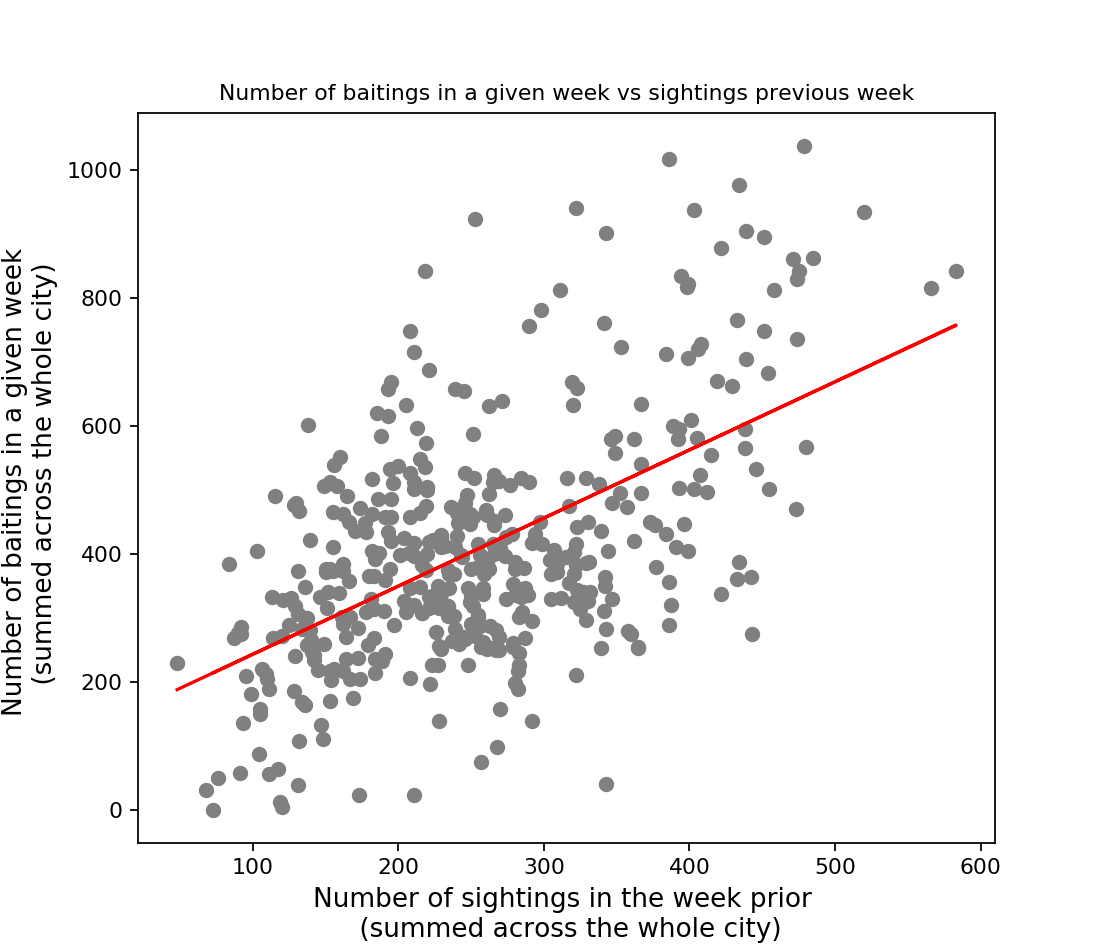

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     195.7
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           8.59e-37
Time:                        17:46:31   Log-Likelihood:                -2731.0
No. Observations:                 423   AIC:                             5466.
Df Residuals:                     421   BIC:                             5474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.4833     20.771      6.571      0.000      95.656     177.310
x1             1.0650      0.076     13.990      0.000       0.915       1.215
==============================================================================
Omnibus:                       16.544   Durbin-Watson:                   0.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.444
Skew:                           0.464   Prob(JB):                     0.000163
Kurtosis:                       3.357   Cond. No.                         755.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
### sightings_last_week = number of sightings last week, so what is assigned to week 2010-10-04 is the number of sightings the week before this date
sightings_last_week = pd.DataFrame({'Created Date':sightings_by_week['Created Date'],'sightings': sightings_by_week['Descriptor']})
sightings_last_week['Created Date'] = sightings_last_week['Created Date'] + timedelta(days=7)

sightings_last_week_baitings_this_week = pd.merge(baitings_by_week.iloc[:,1:3],sightings_last_week, how='right', on=['Created Date']).fillna(0).sort_values('Created Date')
sightings_last_week_baitings_this_week.columns = ['Created Date','baitings','sightings']

X = sightings_last_week_baitings_this_week['sightings'].values
X = sm.add_constant(X)
Y = sightings_last_week_baitings_this_week['baitings'].values
lg_sightings_last_week_baitings_this_week = sm.OLS(Y,X).fit()

fig = plt.figure(figsize=(7, 6))
plt.scatter(sightings_last_week_baitings_this_week['sightings'].values,sightings_last_week_baitings_this_week['baitings'].values, marker='o',color = 'gray')
plt.plot(X[:,1], lg_sightings_last_week_baitings_this_week.fittedvalues,'r')
plt.title("Number of baitings in a given week vs sightings previous week", fontsize=10)
plt.xlabel("Number of sightings in the week prior \n (summed across the whole city)", fontsize=12)
plt.ylabel("Number of baitings in a given week \n (summed across the whole city)", fontsize=12) 
plt.show()
lg_sightings_last_week_baitings_this_week.summary()

Looks very similar to when I looked at both measure in the same week.

Now I want to check how the City distributes these interventions across different neighborhoods. I saw that when there are more rat sightings in a week, there are more rat interventions that week. And when there are more rat sightings in a given week, there are more interventions the week after. Is that also true if I look at it by zipcode - so is it the case that there are more interventions in the neighbourhoods where there are more sightings?

<IPython.core.display.Javascript object>


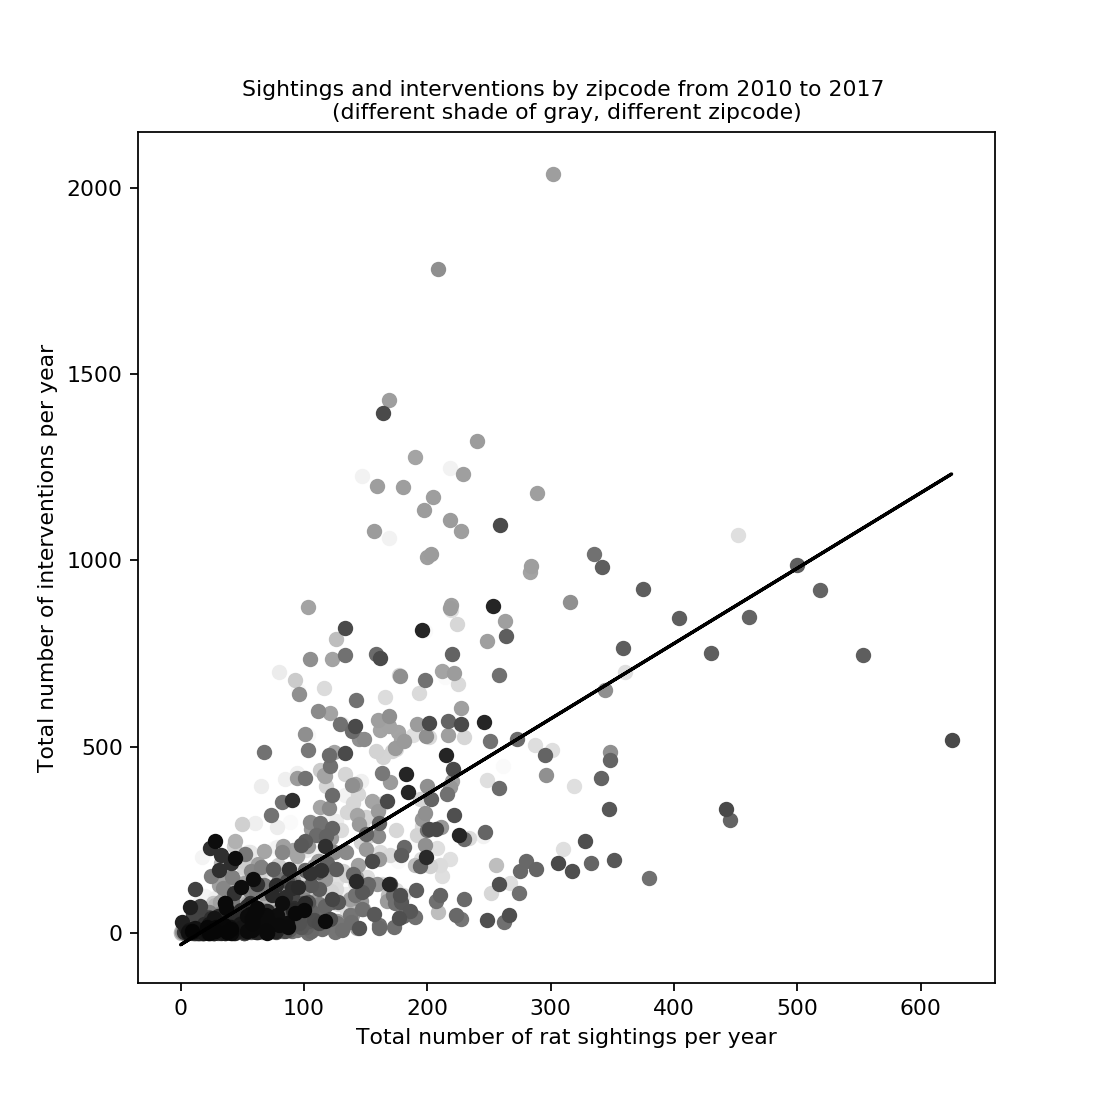

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     890.6
Date:                Tue, 20 Feb 2018   Prob (F-statistic):          2.18e-145
Time:                        17:46:42   Log-Likelihood:                -7653.9
No. Observations:                1152   AIC:                         1.531e+04
Df Residuals:                    1150   BIC:                         1.532e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.7856      8.143     -3.904      0.000     -47.762     -15.810
x1             2.0217      0.068     29.843      0.000       1.889       2.155
==============================================================================
Omnibus:                      666.318   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8640.516
Skew:                           2.415   Prob(JB):                         0.00
Kurtosis:                      15.517   Cond. No.                         179.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
fig = plt.figure(figsize=(7, 7))
cmap = plt.get_cmap('binary')
colors = [cmap(i) for i in np.linspace(0, 1, 197)]
k=0

bait_interventions = bait_interventions[bait_interventions['YearMonth'] != '2018-01']
dataset_sightings = dataset_sightings[dataset_sightings['YearMonth'] != '2018-01']
dataset_sightings = dataset_sightings[dataset_sightings['YearMonth'] != '2018-02']


list_yearly_sightings = []
list_yearly_baitings = []

for name, group in dataset_sightings.groupby('Incident Zip'):
    sightings_by_year_this_zipcode = group.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='AS')])['Descriptor'].size().reset_index().sort_values('Created Date')
    baitings_this_zipcode = bait_interventions[bait_interventions['ZIP_CODE'] == name]
    baitings_by_year_this_zipcode = baitings_this_zipcode.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='AS')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')
    baitings_by_year_this_zipcode.columns = ['type', 'Created Date','Inspections']
    sightings_baitings_this_zipcode_by_year = pd.merge(sightings_by_year_this_zipcode.iloc[:,1:3],baitings_by_year_this_zipcode.iloc[:,1:3], how='right', on=['Created Date']).fillna(0).sort_values('Created Date')
    plt.scatter(sightings_baitings_this_zipcode_by_year['Descriptor'],sightings_baitings_this_zipcode_by_year['Inspections'], color = colors[k], label = str(int(name)))
    list_yearly_sightings = np.append(list_yearly_sightings,sightings_baitings_this_zipcode_by_year['Descriptor'])
    list_yearly_baitings = np.append(list_yearly_baitings,sightings_baitings_this_zipcode_by_year['Inspections'])
    k+=1    
       
X = list_yearly_sightings
X = sm.add_constant(X)
Y = list_yearly_baitings
lg_by_zip = sm.OLS(Y,X).fit()
plt.plot(X[:,1], lg_by_zip.fittedvalues,'k')
# plt.legend(loc='center left', bbox_to_anchor=(0.8, 0.7))
plt.xlabel("Total number of rat sightings per year", fontsize=10)
plt.ylabel("Total number of interventions per year", fontsize=10)
plt.title('Sightings and interventions by zipcode from 2010 to 2017 \n(different shade of gray, different zipcode)',fontsize=10)
plt.savefig('SightVsBaitByZipcode.jpg', dpi=200)
plt.show()
lg_by_zip.summary()

The above plot and linear regression model shows that the yearly total number of rat sightings for a given zipcode is correlated to the yearly total number of rat interventions at that zipcode (R^2 = 0.44) and the relation is significant (p-values 0.0000). This is also true if I look at total sightings/interventions per month or per week, but the deviations are much larger in those cases so the fit is worse, but still significant. So it is indeed the case that on average there are more interventions at locations where there are more rat sightings. (Just a note on this reasoning: once could also flip it and say there are more rat sightings where there are more interventions. Both are independent of one another in both ways no? So all I can say is that there is a correlation) On average in the period 2010-2017 a neighborhood "needs" at least around 7 rat sightings per year to start getting interventions. And on average in this time period a neighborhood with additional 100 rat sightings per year, has beween 189 and 215 additional interventions per year. One thing I notice because I plotted each zipcode with a different shade is that some zipcodes seem to separate into different clusters. A couple zipcodes are consistently above the regression line and a couple are consistently below.<br>
These zipcodes could be interesting to look at, let me look at a couple zipcodes that have most rat sightings and compare number of rat sightings per month vs. number of rat interventions per month at that zipcode.

<IPython.core.display.Javascript object>


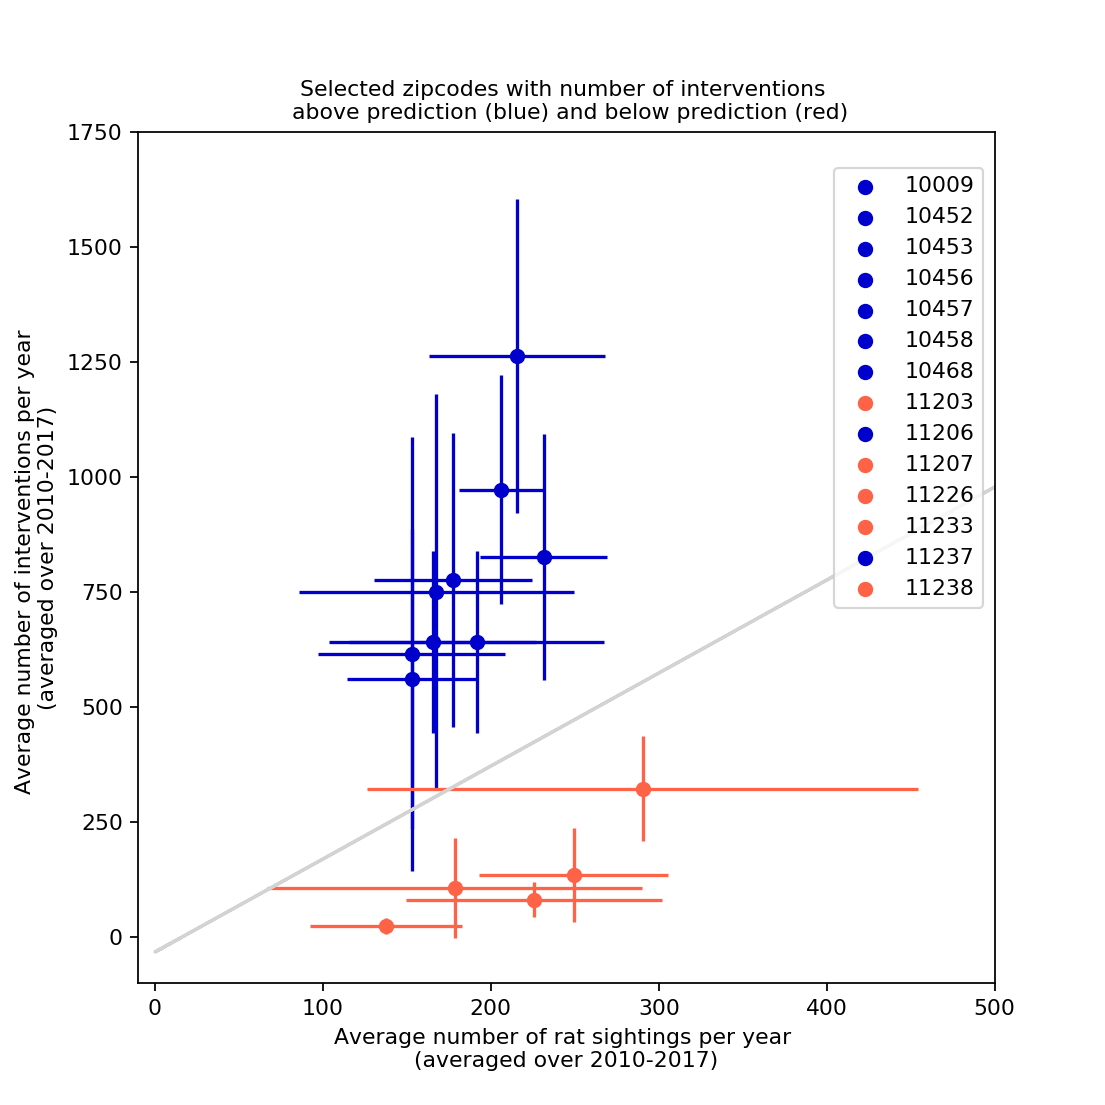

In [29]:
fig = plt.figure(figsize=(7, 7))
two_colors = ['tomato','k','mediumblue']

slope_pred = lg_by_zip.params[1]
interc_pred = lg_by_zip.params[0]

deviation_by_zipcode = {}
deviant_zips = []

for name, group in dataset_sightings.groupby('Incident Zip'):
    sightings_by_year_this_zipcode = group.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='AS')])['Descriptor'].size().reset_index().sort_values('Created Date')
    baitings_this_zipcode = bait_interventions[bait_interventions['ZIP_CODE'] == name]
    baitings_by_year_this_zipcode = baitings_this_zipcode.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='AS')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')
    baitings_by_year_this_zipcode.columns = ['type', 'Created Date','Inspections']
    sightings_baitings_this_zipcode_by_year = pd.merge(sightings_by_year_this_zipcode.iloc[:,1:3],baitings_by_year_this_zipcode.iloc[:,1:3], how='right', on=['Created Date']).fillna(0).sort_values('Created Date')

    deviation_from_fit = sightings_baitings_this_zipcode_by_year['Inspections'].mean()- (sightings_baitings_this_zipcode_by_year['Descriptor'].mean()*slope_pred + interc_pred)
    if abs(deviation_from_fit) >220:        
        plt.scatter(sightings_baitings_this_zipcode_by_year['Descriptor'].mean(),sightings_baitings_this_zipcode_by_year['Inspections'].mean(), color = two_colors[int(deviation_from_fit/abs(deviation_from_fit)+1)], label = str(int(name)))
        plt.errorbar(sightings_baitings_this_zipcode_by_year['Descriptor'].mean(),sightings_baitings_this_zipcode_by_year['Inspections'].mean(),xerr = sightings_baitings_this_zipcode_by_year['Descriptor'].std(),yerr = sightings_baitings_this_zipcode_by_year['Inspections'].std(),color = two_colors[int(deviation_from_fit/abs(deviation_from_fit)+1)])    
        deviation_by_zipcode[int(name)] = [deviation_from_fit,sightings_baitings_this_zipcode_by_year['Inspections'].mean()]
        deviant_zips = np.append(deviant_zips,name)
    k+=1    
       
plt.legend(loc='center left', bbox_to_anchor=(0.8, 0.7))
plt.xlabel("Average number of rat sightings per year \n(averaged over 2010-2017)", fontsize=10)
plt.ylabel("Average number of interventions per year \n(averaged over 2010-2017)", fontsize=10)
plt.title('Selected zipcodes with number of interventions \n above prediction (blue) and below prediction (red)',fontsize=10)
plt.plot(X[:,1], lg_by_zip.fittedvalues,color = 'lightgray')
plt.axis([-10,500,-100,1750])
plt.show()
plt.savefig('SightVsBaitByZipcode_Deviants.jpg', dpi=200)


In [30]:
### zipcodes and their deviation from prediction 
sorted(deviation_by_zipcode.items(), key=operator.itemgetter(1), reverse=True)

[(10457, [859.35170413348646, 1263.75]),
 (10458, [588.69108940158958, 973.125]),
 (11237, [449.18210783018952, 776.25]),
 (10468, [443.89649309829258, 751.0]),
 (10456, [391.25977319954995, 827.5]),
 (10453, [339.57305411214014, 641.875]),
 (10009, [339.46942786923262, 616.5]),
 (11206, [287.3781692222459, 642.75]),
 (10452, [284.34442786923262, 561.375]),
 (11203, [-220.82449614711453, 25.375]),
 (11226, [-221.08688833280695, 107.75]),
 (11238, [-232.52111093392671, 323.0]),
 (11233, [-336.37557753552142, 135.75]),
 (11207, [-342.36539487218749, 82.25])]

One extreme difference I can point out is the difference between a couple Bronx zip codes (10456, 10457, 10458, 10468) - around Fordham University that have on average between 327 and 795 MORE rat interventions per year than predicted. On the other all the zipcodes with far fewer interventions than predicted are Brooklyn zip codes (11238,11233,11207,...) - part of Crown Heights, Bed-Stuy, South-East Brooklyn... that have on average up to 400 FEWER rat interventions per year than predicted. In many of these Bronx and Brooklyn neighborhoods the numbers of rat sightings are comparable if not even indistinguishable, yet the number of interventions are on average at least 7 times higher in the Bronx zipcodes.<br>
I will test statictical significance for two zipcodes:

<IPython.core.display.Javascript object>


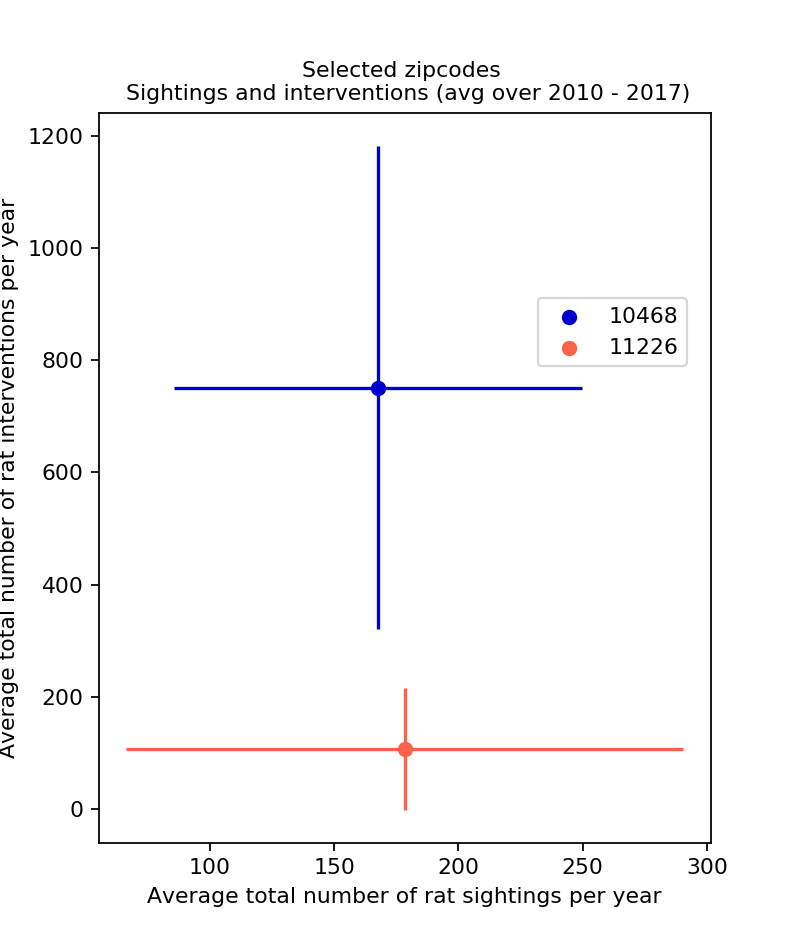

In [31]:
fig = plt.figure(figsize=(5, 6))
cmap = plt.get_cmap('seismic')
colors = ['mediumblue','tomato']
k=0
comparison_sightings = {}
comparison_baitings = {}

for name in [10468,11226]:
    this_zipcode_sightings = dataset_sightings[dataset_sightings['Incident Zip'] == name]
    sightings_by_year_this_zipcode = this_zipcode_sightings.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='AS')])['Descriptor'].size().reset_index().sort_values('Created Date')
    baitings_this_zipcode = bait_interventions[bait_interventions['ZIP_CODE'] == name]
    baitings_by_year_this_zipcode = baitings_this_zipcode.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='AS')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')
    baitings_by_year_this_zipcode.columns = ['type', 'Created Date','Inspections']
    sightings_baitings_this_zipcode_by_year = pd.merge(sightings_by_year_this_zipcode.iloc[:,1:3],baitings_by_year_this_zipcode.iloc[:,1:3], how='right', on=['Created Date']).fillna(0).sort_values('Created Date')
    plt.scatter(sightings_baitings_this_zipcode_by_year['Descriptor'].mean(),sightings_baitings_this_zipcode_by_year['Inspections'].mean(), color = colors[k], label = str(int(name)))
    plt.errorbar(sightings_baitings_this_zipcode_by_year['Descriptor'].mean(),sightings_baitings_this_zipcode_by_year['Inspections'].mean(),xerr = sightings_baitings_this_zipcode_by_year['Descriptor'].std(),yerr = sightings_baitings_this_zipcode_by_year['Inspections'].std(),color = colors[k])    
      
    comparison_sightings[str(int(name))] = sightings_baitings_this_zipcode_by_year['Descriptor'].values
    comparison_baitings[str(int(name))] = sightings_baitings_this_zipcode_by_year['Inspections'] .values
    k+=1
    
plt.xlabel("Average total number of rat sightings per year", fontsize=10)
plt.ylabel("Average total number of rat interventions per year", fontsize=10)
plt.title('Selected zipcodes \n Sightings and interventions (avg over 2010 - 2017)',fontsize=10)
# plt.axis([5,45,-2,180])

plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.7))

plt.show()

In [32]:
fsight,psight = stats.f_oneway(comparison_sightings['10468'],comparison_sightings['11226'])
fbait, pbait = stats.f_oneway(comparison_baitings['10468'],comparison_baitings['11226'])
print ('p-value of an ANOVA between the two zipcodes for number of sightings in each month is {:.5f}'.format(psight))
print ('p-value of an ANOVA between the two zipcodes for number of interventions in each month is {:.5f}'.format(pbait))
print ('In these two zipcodes there are on average {:.0f} rat sightings per year.'.format(comparison_sightings['10468'].mean()))
print ('At zipcode 10468 there have been on average {:.0f} more rat interventions per year than at zipcode 11226.'.format(comparison_baitings['10468'].mean()-comparison_baitings['11226'].mean()))
print ('Which is a difference of {:.3f}% more rat interventions per year at zipcode 10468.'.format(100*(comparison_baitings['10468'].mean()-comparison_baitings['11226'].mean())/comparison_baitings['11226'].mean()))

p-value of an ANOVA between the two zipcodes for number of sightings in each month is 0.82977
p-value of an ANOVA between the two zipcodes for number of interventions in each month is 0.00108
In these two zipcodes there are on average 168 rat sightings per year.
At zipcode 10468 there have been on average 643 more rat interventions per year than at zipcode 11226.
Which is a difference of 596.984% more rat interventions per year at zipcode 10468.


It will be interesting to further investigate in what ways these neighborhoods are different to try to see if I can find any possible indication of what impact such a different level of interventions has.


<IPython.core.display.Javascript object>


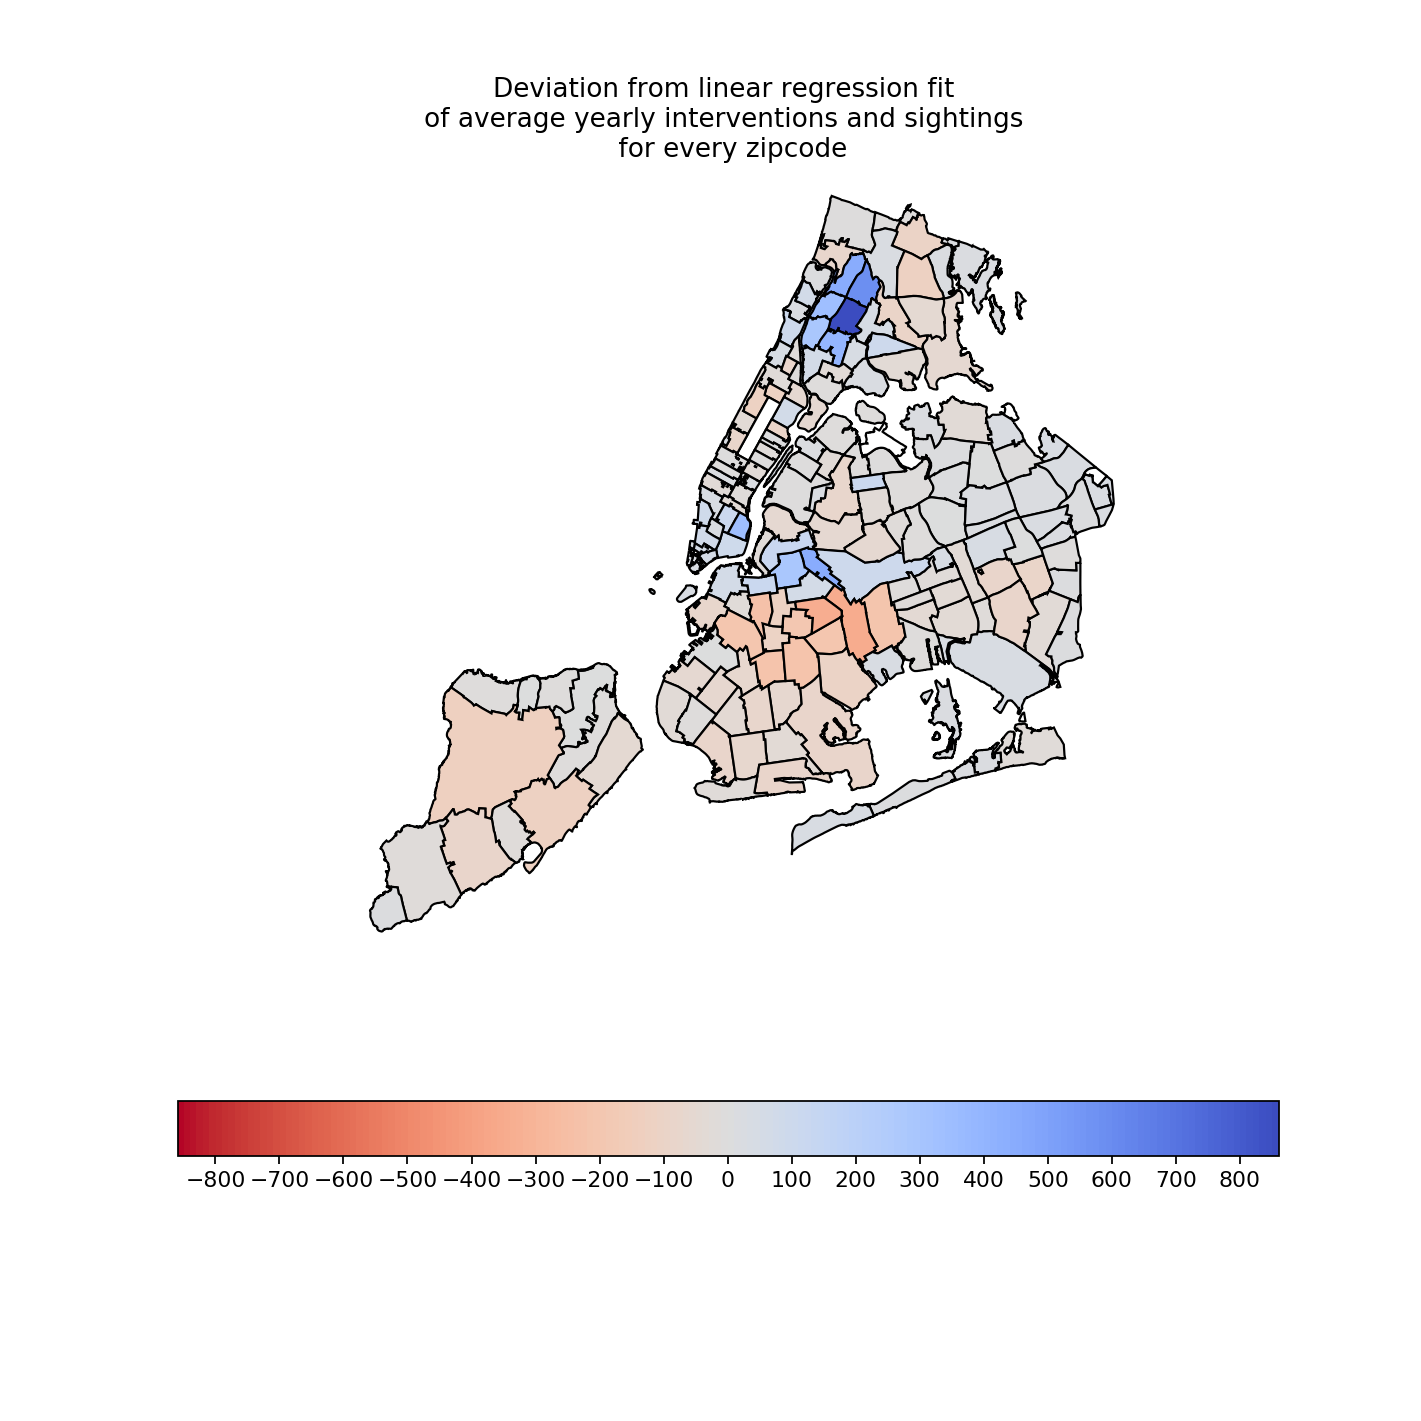

In [34]:
### let me color each zipcode according to its deviation of average interventions/sightings from the linear regression prediction for inspections vs. sightings  
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import shapefile
sf = shapefile.Reader("ZIP_CODE_040114/ZIP_CODE_040114")
plt.figure(figsize=(9, 9))
ax = plt.axes() # add the axes
ax.set_aspect('equal')

fld = sf.fields[1:]
field_names = [field[0] for field in fld]
fld_name='ZIPCODE'
fld_ndx=field_names.index(fld_name)


### how will I color code the zipcodes:
myzipcodes ={}
for name, group in dataset_sightings.groupby('Incident Zip'):
    sightings_by_year_this_zipcode = group.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='AS')])['Descriptor'].size().reset_index().sort_values('Created Date')
    baitings_this_zipcode = bait_interventions[bait_interventions['ZIP_CODE'] == name]
    baitings_by_year_this_zipcode = baitings_this_zipcode.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='AS')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')
    baitings_by_year_this_zipcode.columns = ['type', 'Created Date','Inspections']
    myzipcodes[str(int(name))] = np.nan_to_num(baitings_by_year_this_zipcode['Inspections'].mean())- np.nan_to_num((sightings_by_year_this_zipcode['Descriptor'].mean())*slope_pred + interc_pred)
    
max_value = sorted(myzipcodes.items(), key=operator.itemgetter(1), reverse=True)[0][1]   
min_value = sorted(myzipcodes.items(), key=operator.itemgetter(1), reverse=True)[-1][1]
    
cmap = plt.get_cmap('coolwarm_r')

### To create a legend: Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(-int(max_value),int(max_value)+10,10)
CS3 = plt.contourf(Z, levels, cmap=cmap)

colors = [cmap(i) for i in np.linspace(0, 1, 2*int(max_value)+1)]
icolor = 1
for shapeRec in sf.iterShapeRecords():
    
    shape=shapeRec.shape
    rec = shapeRec.record
    
    zip_this_polygon = rec[fld_ndx]
    if zip_this_polygon in myzipcodes:
        icolor = myzipcodes[zip_this_polygon] + abs(max_value)
        zip_color = colors[int(icolor)]
    else:
        zip_color = 'w'

    # define polygon fill color (facecolor) RGB values:
#     zip_color = colors[int(icolor)]
#     R = (float(icolor))/(max_value-min_value)
#     G = 0
#     B = 0

    # check number of parts (could use MultiPolygon class of shapely?)
    nparts = len(shape.parts) # total parts
    if nparts == 1:
        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=zip_color, alpha=1.0, zorder=2)
        ax.add_patch(patch)

    else: # loop over parts of each shape, plot separately
        for ip in range(nparts): # loop over parts, plot separately
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)

            polygon = Polygon(shape.points[i0:i1+1])
            patch = PolygonPatch(polygon, facecolor=zip_color, alpha=1.0, zorder=2)
            ax.add_patch(patch)


plt.axis([900000,1075000,119000,278000])
plt.colorbar(CS3,ticks=[np.linspace(-800, 800, 17)],orientation='horizontal') # using the colorbar info I got from contourf
plt.title('Deviation from linear regression fit \nof average yearly interventions and sightings \n for every zipcode')
plt.axis('off')
plt.show()
plt.savefig('SightVsBaitByZipcode_DeviationAmount_Map.jpg', dpi=200)




Let me now check how sightings are distributed in time, in particular what is the distribution of times bewteen two consecutive sightings. Across the whole city and within a given zipcode.

In [35]:
### across the City there is a sighting every single day since 2010 except for one day in 2012:

df_sightings_sorted_dates = dataset_sightings.sort_values(by=['Created Date'])
sightings_every_day = df_sightings_sorted_dates.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='D')])['Descriptor'].size().reset_index().sort_values('Created Date')
### number of days that didn't have a single rat sighting since 2010:
diffs_sightings = sightings_every_day['Created Date'].values[1:] - sightings_every_day['Created Date'].values[:-1]
time_btw_sightings = diffs_sightings/np.timedelta64(1, 'D')  
day_no_sight = np.nonzero(time_btw_sightings>1)[0].size
print ('Number of days without any rat sightings anywhere in NYC since 2010: {}'.format(day_no_sight))
indx = np.nonzero(time_btw_sightings>1)[0][0]
day_without = (sightings_every_day.iloc[indx,1] + np.timedelta64(1, 'D')).strftime('%Y-%m-%d') 
print ('The only day without any rat sightings anywhere in NYC since 2010: {}'.format(day_without))
sightings_every_day.iloc[indx-3:indx+3,:]

Number of days without any rat sightings anywhere in NYC since 2010: 1
The only day without any rat sightings anywhere in NYC since 2010: 2012-06-03


,Agency Name,Created Date,Descriptor
880,Department of Health and Mental Hygiene,2012-05-30,63
881,Department of Health and Mental Hygiene,2012-05-31,70
882,Department of Health and Mental Hygiene,2012-06-01,52
883,Department of Health and Mental Hygiene,2012-06-02,15
884,Department of Health and Mental Hygiene,2012-06-04,71
885,Department of Health and Mental Hygiene,2012-06-05,48


But given that all days around 2012-06-03 have many sightings this is likely a mistake in the dataset. So it could be that there has not been a single day in NYC without a rat sighting since 2010.

<IPython.core.display.Javascript object>


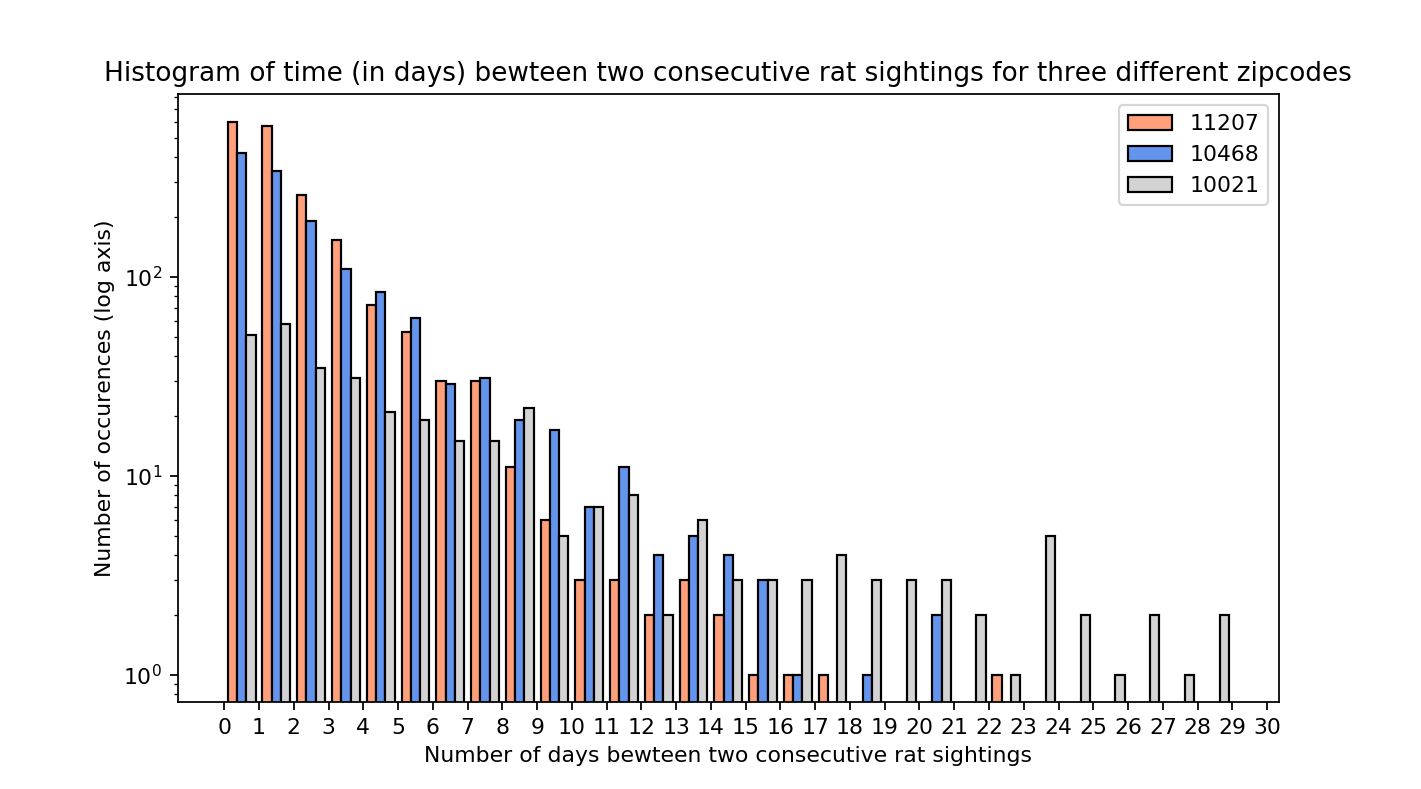

In [36]:
### how about distribution of times bewteen two consecutive sightings for each zipcode

time_btw_sightings_in_days = {} ### will contain times bewteen two consecutive sightings for each zipcode

for name, group in dataset_sightings.groupby('Incident Zip'):

    df_sightings_sorted_dates = group.sort_values(by=['Created Date'])
    diffs_sightings = df_sightings_sorted_dates['Created Date'].values[1:] - df_sightings_sorted_dates['Created Date'].values[:-1]
    time_btw_sightings_in_days[name] = diffs_sightings/np.timedelta64(1, 'D')    

### plot the histogram for a couple zipcodes
bin_values = np.arange(start=0, stop=30, step=1)
plt.figure(figsize=(9, 5))

plt.hist((time_btw_sightings_in_days[11207],time_btw_sightings_in_days[10468],time_btw_sightings_in_days[10021]), bins=bin_values, color = ("lightsalmon","cornflowerblue","lightgray"), ec = 'k',label = ("11207", "10468","10021"))
plt.legend()
plt.title('Histogram of time (in days) bewteen two consecutive rat sightings for three different zipcodes')
plt.xticks(np.linspace(0,30,31))
plt.xlabel('Number of days bewteen two consecutive rat sightings')
plt.ylabel('Number of occurences (log axis)')
plt.yscale('log')
plt.savefig('InterSightTimesDistr.jpg', dpi=200)
plt.show()

<IPython.core.display.Javascript object>


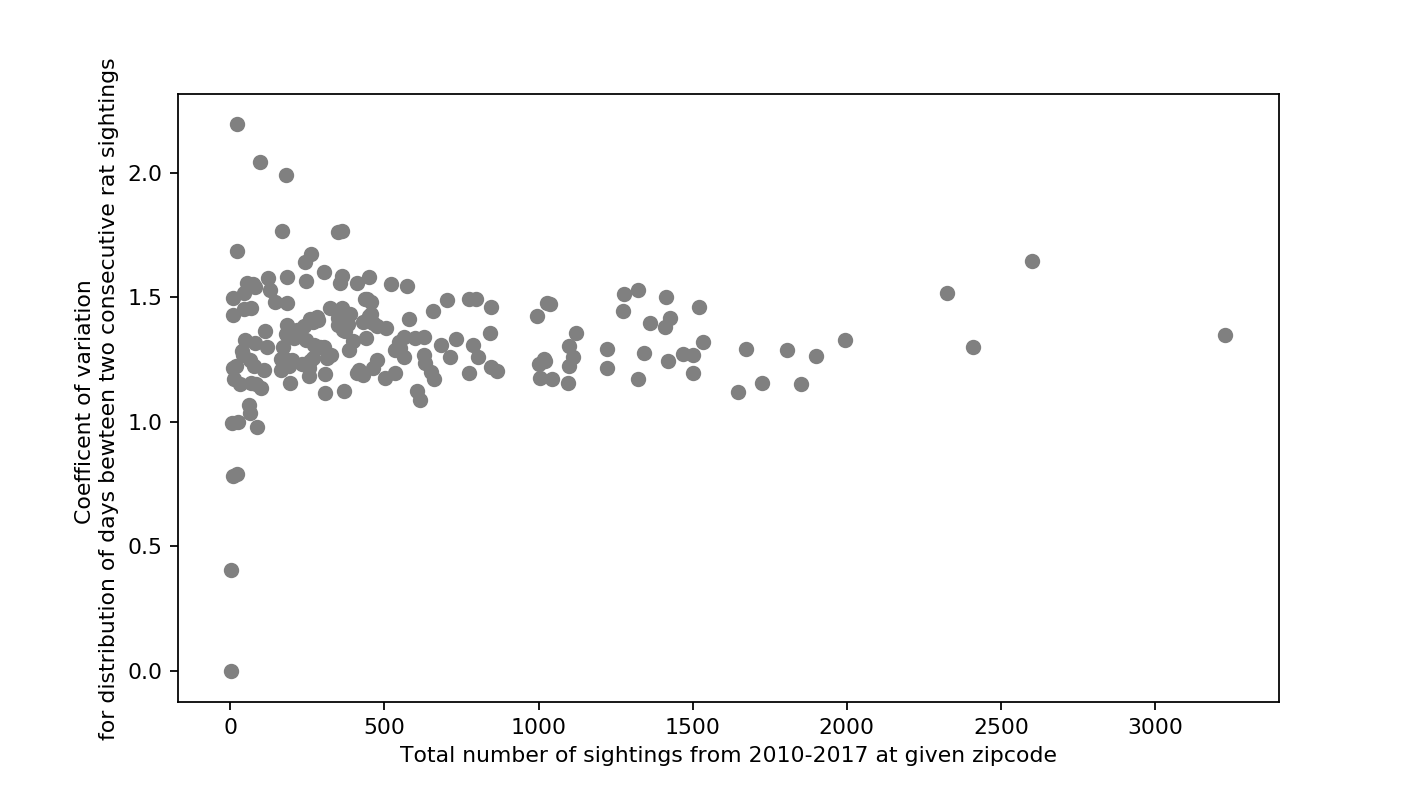

In [37]:
### measure of burstiness = coefficent of variation for distribution of days bewteen two consecutive rat sightings 
coef_var_sightings = {}  ### will contain coefficent of variation for rat sightings for each zipcode
for key in time_btw_sightings_in_days:
    if time_btw_sightings_in_days[key].size>0:
        coef_var_sightings[key] = time_btw_sightings_in_days[key].std()/time_btw_sightings_in_days[key].mean()

plt.figure(figsize=(9, 5))

for name, group in dataset_sightings.groupby('Incident Zip'):
    sightings_by_year_this_zipcode = group.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='AS')])['Descriptor'].size().reset_index().sort_values('Created Date')
    if name in coef_var_sightings:
        plt.scatter(sightings_by_year_this_zipcode['Descriptor'].sum(),coef_var_sightings[name],color = 'gray')
        
plt.xlabel('Total number of sightings from 2010-2017 at given zipcode')
plt.ylabel('Coefficent of variation \nfor distribution of days bewteen two consecutive rat sightings')
plt.show()

Number of days without any rat interventions anywhere in NYC since 2010: 355


<IPython.core.display.Javascript object>


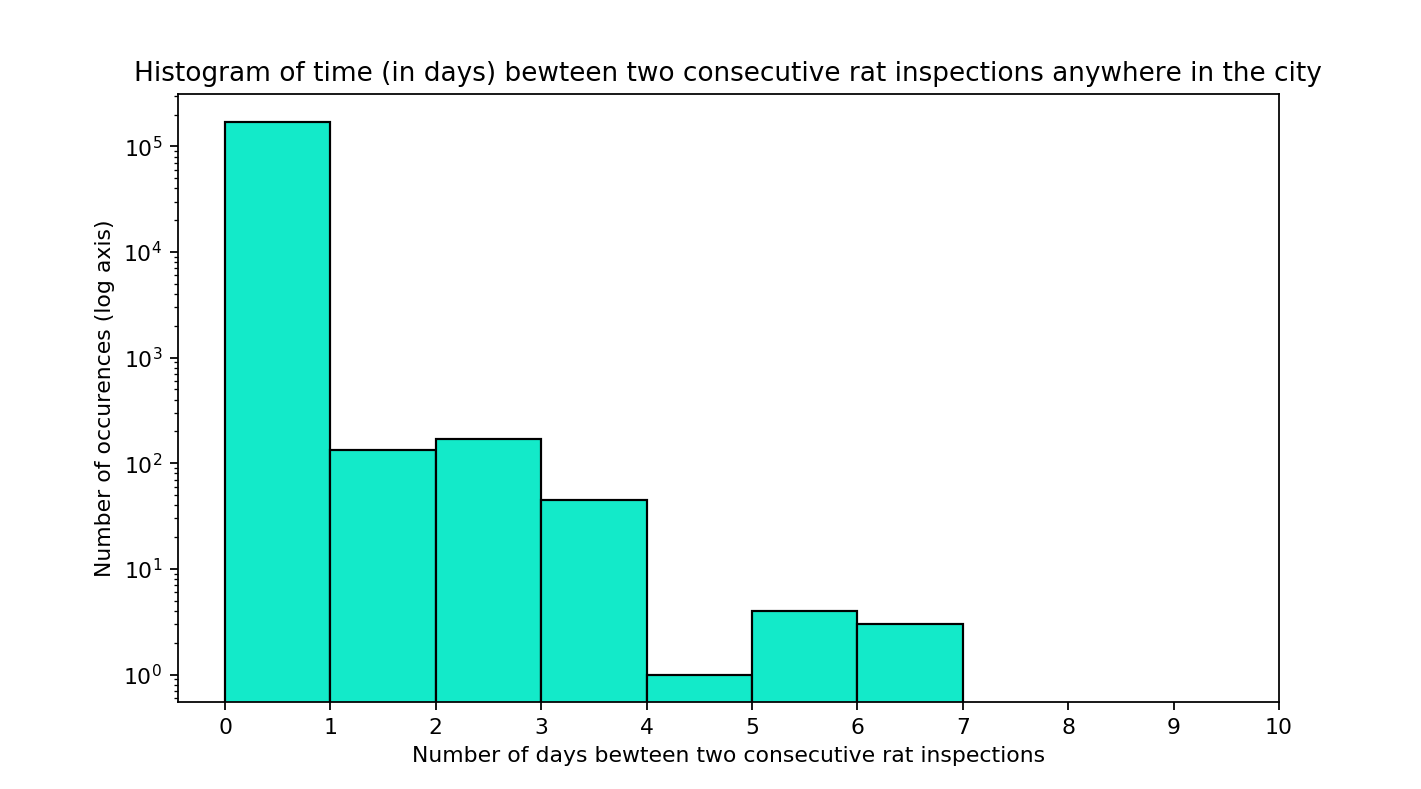

In [921]:
### now let me look at distribution of times bewteen two consecutive inspections - first across the whole city

df_baitings_sorted_dates = bait_interventions.sort_values(by=['INSPECTION_DATE'])
### number of days that didn't have a single rat intervention since 2010:
diffs_baitings = df_baitings_sorted_dates['INSPECTION_DATE'].values[1:] - df_baitings_sorted_dates['INSPECTION_DATE'].values[:-1]
time_btw_baitings = diffs_baitings/np.timedelta64(1, 'D')  
day_no_baitings = np.nonzero(time_btw_baitings>1)[0].size
print ('Number of days without any rat interventions anywhere in NYC since 2010: {}'.format(day_no_baitings))

plt.figure(figsize=(9, 5))
bin_values = np.arange(start=0, stop=10, step=1)
plt.hist(time_btw_baitings, bins=bin_values,color = 'xkcd:aqua',ec = 'k')
plt.title('Histogram of time (in days) bewteen two consecutive rat inspections anywhere in the city')
plt.xticks(np.linspace(0,10,11))
plt.xlabel('Number of days bewteen two consecutive rat inspections')
plt.ylabel('Number of occurences (log axis)')
plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


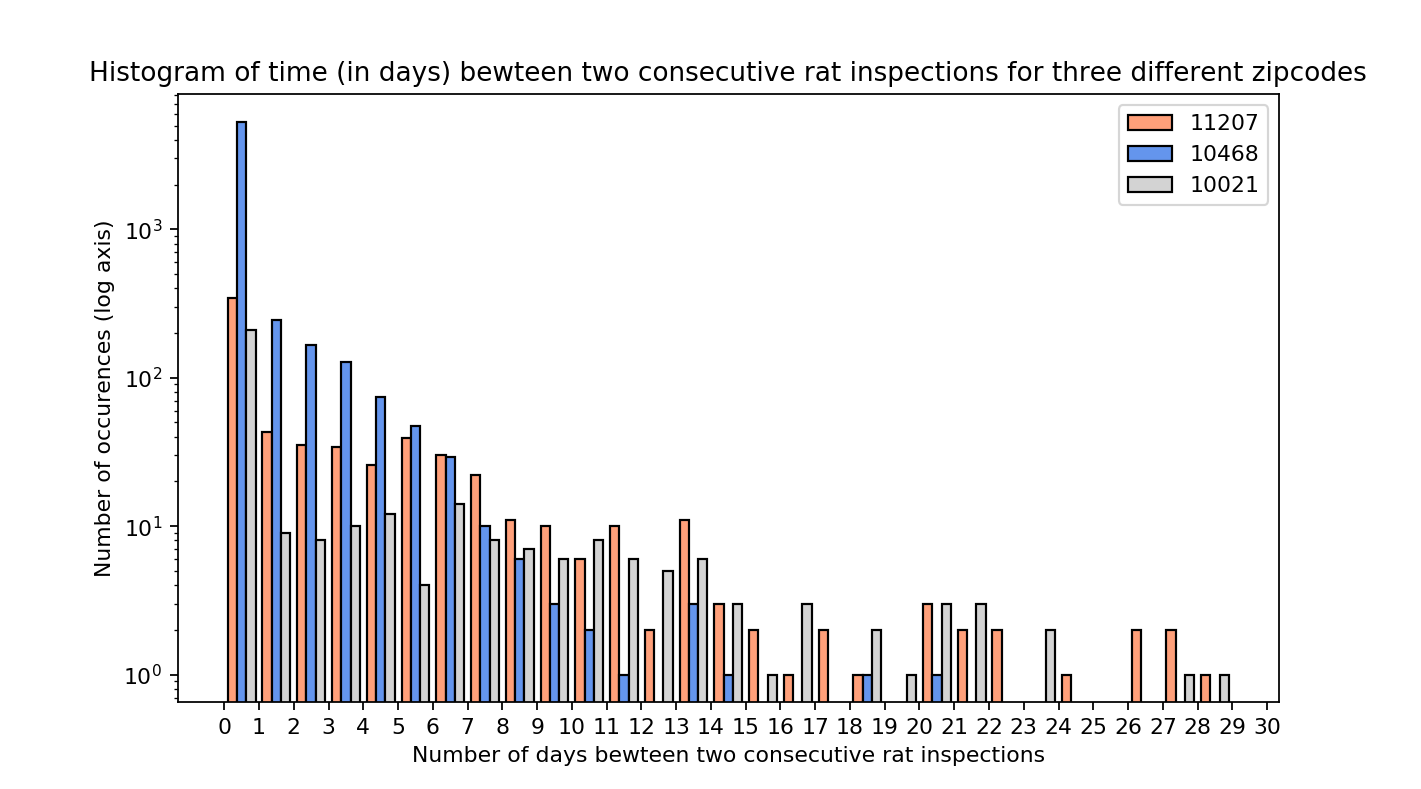

In [969]:
### now let me look at distribution of times bewteen two consecutive inspections for each zipcode

time_btw_baitings_in_days = {} ### will contain times bewteen two consecutive inspections for each zipcode

for name, group in bait_interventions.groupby('ZIP_CODE'):
    
    df_baitings_sorted_dates = group.sort_values(by=['INSPECTION_DATE'])
    diffs_baitings = df_baitings_sorted_dates['INSPECTION_DATE'].values[1:] - df_baitings_sorted_dates['INSPECTION_DATE'].values[:-1]
    time_btw_baitings_in_days[name] = diffs_baitings/np.timedelta64(1, 'D')    

### plot the histogram for a couple zipcodes
bin_values = np.arange(start=0, stop=30, step=1)
plt.figure(figsize=(9, 5))

plt.hist((time_btw_baitings_in_days[11207],time_btw_baitings_in_days[10468],time_btw_baitings_in_days[10021]), bins=bin_values, color = ("lightsalmon","cornflowerblue","lightgray"), ec = 'k',label = ("11207", "10468","10021"))
plt.legend()
plt.title('Histogram of time (in days) bewteen two consecutive rat inspections for three different zipcodes')
plt.xticks(np.linspace(0,30,31))
plt.xlabel('Number of days bewteen two consecutive rat inspections')
plt.ylabel('Number of occurences (log axis)')
plt.yscale('log')
plt.savefig('InterBaitTimesDistr.jpg', dpi=200)

plt.show()

<IPython.core.display.Javascript object>


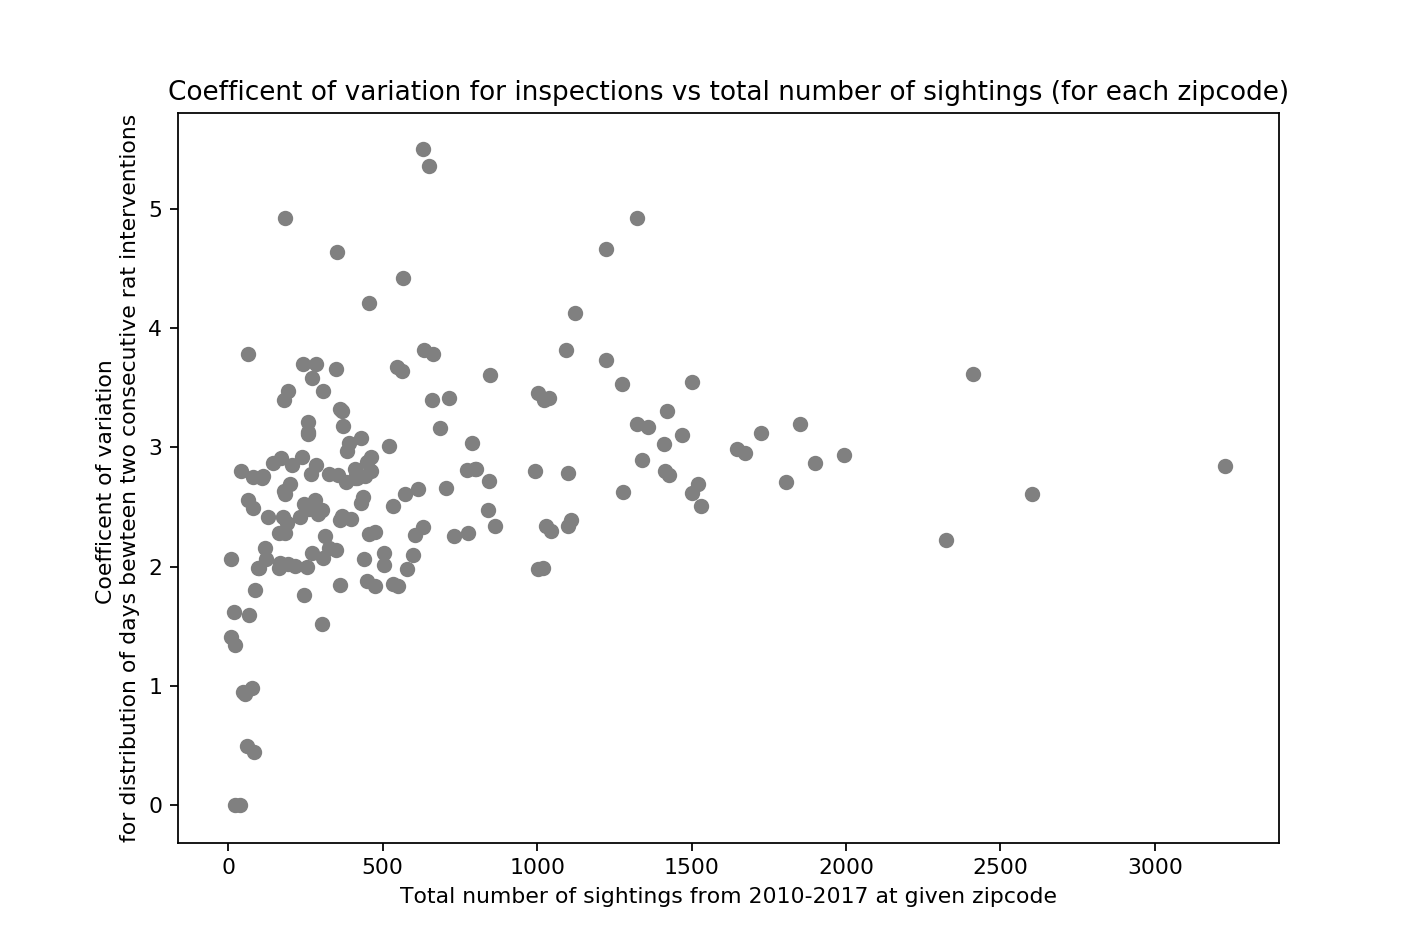

In [923]:
### measure of burstiness = coefficent of variation for distribution of days bewteen two consecutive rat inspections 
coef_var_baitings = {}  ### will contain coefficent of variation for rat sightings for each zipcode
for key in time_btw_baitings_in_days:
    if time_btw_baitings_in_days[key].size>0:
        coef_var_baitings[key] = time_btw_baitings_in_days[key].std()/time_btw_baitings_in_days[key].mean()

plt.figure(figsize=(9, 6))

for name, group in dataset_sightings.groupby('Incident Zip'):
    sightings_by_year_this_zipcode = group.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='AS')])['Descriptor'].size().reset_index().sort_values('Created Date')
    if name in coef_var_baitings:
        plt.scatter(sightings_by_year_this_zipcode['Descriptor'].sum(),coef_var_baitings[name],color ='gray')
plt.xlabel('Total number of sightings from 2010-2017 at given zipcode')
plt.ylabel('Coefficent of variation \nfor distribution of days bewteen two consecutive rat interventions')
plt.title('Coefficent of variation for inspections vs total number of sightings (for each zipcode)')
plt.show()            

In [946]:
### look at just months when there are most sightings and interventions: May - Sept

time_btw_baitings_in_days_warm_season = {} ### will contain times bewteen two consecutive inspections for each zipcode

just_warm_season = bait_interventions[bait_interventions['INSPECTION_DATE'].dt.month>=5]
just_warm_season = just_warm_season[just_warm_season['INSPECTION_DATE'].dt.month<=9]

for name, group in just_warm_season.groupby('ZIP_CODE'):
    
    df_baitings_sorted_dates = group.sort_values(by=['INSPECTION_DATE'])
    diffs_baitings = df_baitings_sorted_dates['INSPECTION_DATE'].values[1:] - df_baitings_sorted_dates['INSPECTION_DATE'].values[:-1]
    time_btw_baitings_in_days_warm_season[name] = diffs_baitings/np.timedelta64(1, 'D')    
    
    
### measure of burstiness = coefficent of variation for distribution of days bewteen two consecutive rat inspections 
coef_var_baitings_warm_season = {}  ### will contain coefficent of variation for rat sightings for each zipcode
for key in time_btw_baitings_in_days_warm_season:
    if time_btw_baitings_in_days_warm_season[key].size>0:
        coef_var_baitings_warm_season[key] = time_btw_baitings_in_days_warm_season[key].std()/time_btw_baitings_in_days_warm_season[key].mean()


<IPython.core.display.Javascript object>


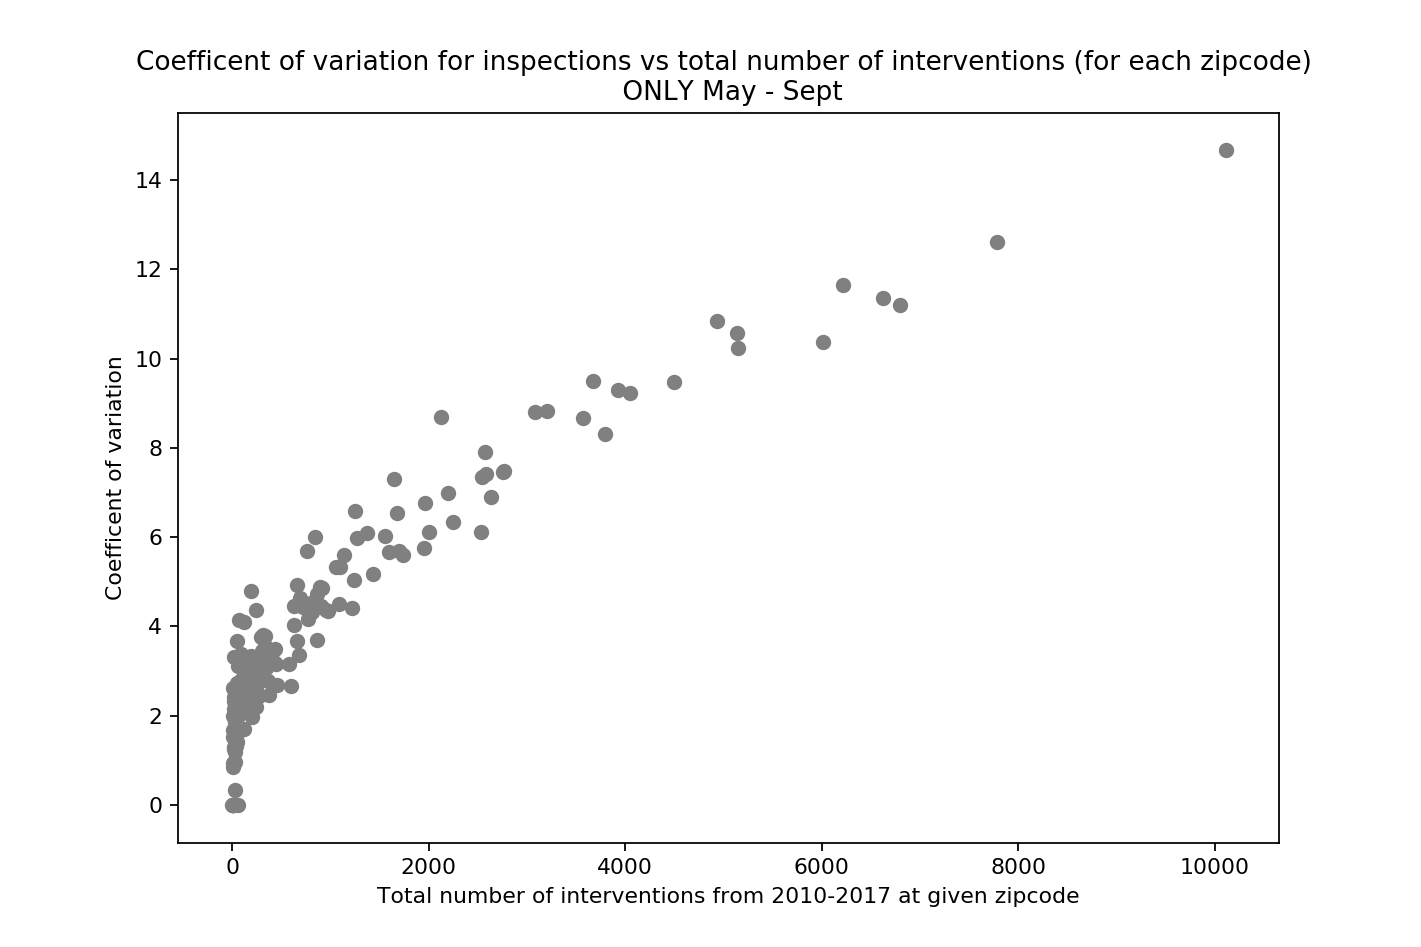

In [947]:
plt.figure(figsize=(9, 6))

for name, group in bait_interventions.groupby('ZIP_CODE'):
    baitings_by_year_this_zipcode = group.groupby(['INSPECTION_TYPE', pd.Grouper(key='INSPECTION_DATE', freq='AS')])['RESULT'].size().reset_index().sort_values('INSPECTION_DATE')
    if name in coef_var_baitings_warm_season:
        plt.scatter(baitings_by_year_this_zipcode['RESULT'].sum(),coef_var_baitings_warm_season[name],color ='gray')
        
        
plt.xlabel('Total number of interventions from 2010-2017 at given zipcode')
plt.ylabel('Coefficent of variation')
plt.title('Coefficent of variation for inspections vs total number of interventions (for each zipcode) \n ONLY May - Sept')
plt.show() 

So in months when there are most rat sightings (May-Sept) the baiting interventions are more bursty in zipcodes that have more total interventions.

<IPython.core.display.Javascript object>


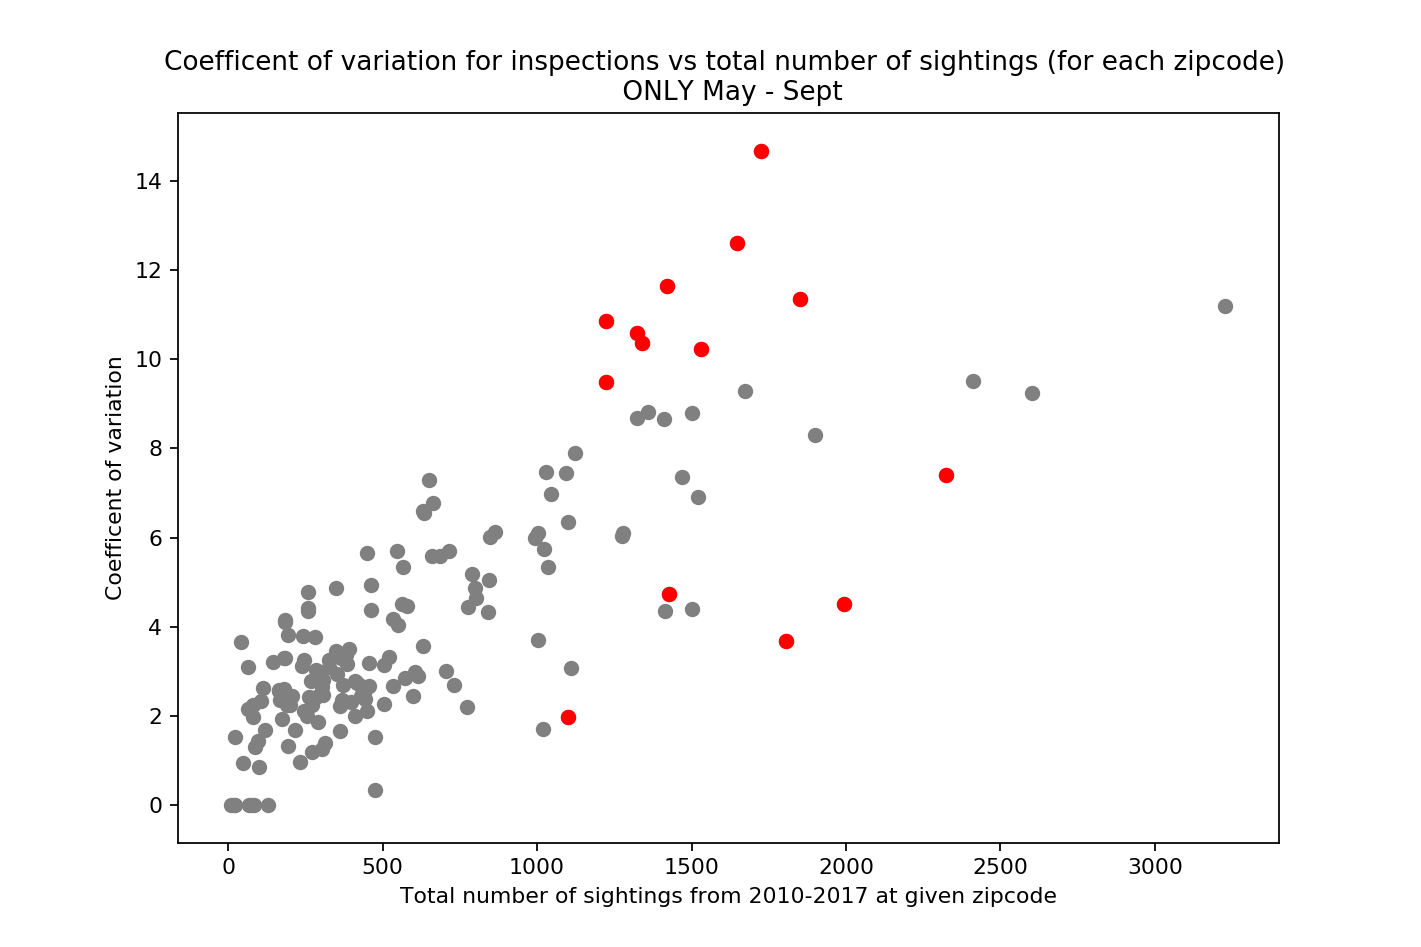

In [945]:
plt.figure(figsize=(9, 6))

for name, group in dataset_sightings.groupby('Incident Zip'):
    sightings_by_year_this_zipcode = group.groupby(['Agency Name', pd.Grouper(key='Created Date', freq='AS')])['Descriptor'].size().reset_index().sort_values('Created Date')
    if name in coef_var_baitings_warm_season:
        plt.scatter(sightings_by_year_this_zipcode['Descriptor'].sum(),coef_var_baitings_warm_season[name],color ='gray')
        if name in deviant_zips:
            plt.scatter(sightings_by_year_this_zipcode['Descriptor'].sum(),coef_var_baitings_warm_season[name],color ='red')
 
        
plt.xlabel('Total number of sightings from 2010-2017 at given zipcode')
plt.ylabel('Coefficent of variation')
plt.title('Coefficent of variation for inspections vs total number of sightings (for each zipcode) \n ONLY May - Sept')
plt.show()     

So in the months that have many rat sightings (May-Sept), the baiting interventions are distributed in time such that for zipcodes with more rat sightings, the interventions are more bursty.

In [953]:
### look at just months when there are most sightings and interventions: May - Sept

time_btw_sightings_in_days_warm_season = {} ### will contain times bewteen two consecutive sightings for each zipcode

just_warm_season = dataset_sightings[dataset_sightings['Created Date'].dt.month>=5]
just_warm_season = just_warm_season[just_warm_season['Created Date'].dt.month<=9]

for name, group in just_warm_season.groupby('Incident Zip'):
    
    df_sightings_sorted_dates = group.sort_values(by=['Created Date'])
    diffs_sightings = df_sightings_sorted_dates['Created Date'].values[1:] - df_sightings_sorted_dates['Created Date'].values[:-1]
    time_btw_sightings_in_days_warm_season[name] = diffs_sightings/np.timedelta64(1, 'D')    
    
    
### measure of burstiness = coefficent of variation for distribution of days bewteen two consecutive rat inspections 
coef_var_sightings_warm_season = {}  ### will contain coefficent of variation for rat sightings for each zipcode
for key in time_btw_sightings_in_days_warm_season:
    if time_btw_sightings_in_days_warm_season[key].size>0:
        coef_var_sightings_warm_season[key] = time_btw_sightings_in_days_warm_season[key].std()/time_btw_sightings_in_days_warm_season[key].mean()
   